In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import math
from timeit import default_timer as timer
from datetime import datetime, timedelta
import numba
from ensemble_processing import load_data, load, save
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series

/Users/neilkloot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/neilkloot/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
import tsfresh
print(tsfresh.__version__)

0.11.1


In [2]:
pd.options.display.max_rows=500
pd.options.display.max_columns=500

In [30]:
experiment_symbols = ['WAX', 'IVV', 'WESN', 'IAA', 'XRO', 'MTB', 'MXR', 'RCP', 'ISX', 'IMI']
# experiment_symbols = ['WAX']

In [31]:
all_df = pd.read_pickle('../data/ml-20180922-labelled.pkl.gz', compression='gzip')
all_df.head(100)

symbol  quoteDate  lastTradePriceOnly  adjustedPrice  volume  \
quoteDate_ref                                                                
2018-05-14       CG1 2018-05-14             0.43000       0.430000   27759   
2018-05-15       CG1 2018-05-15             0.42500       0.425000   45633   
2018-05-17       CG1 2018-05-17             0.42000       0.420000  287372   
2018-05-18       CG1 2018-05-18             0.46500       0.465000   42373   
2018-05-21       CG1 2018-05-21             0.51000       0.510000  229346   
2018-05-22       CG1 2018-05-22             0.50000       0.500000    2378   
2018-05-23       CG1 2018-05-23             0.49000       0.490000   92622   
2018-05-24       CG1 2018-05-24             0.48500       0.485000    2922   
2018-05-25       CG1 2018-05-25             0.47000       0.470000   20404   
2018-05-28       CG1 2018-05-28             0.46500       0.465000    8805   
2018-05-30       CG1 2018-05-30             0.46000       0.460000   47941   
2018-05-31       CG1 2018-05-31             0.46000       0.460000   15165   
2018-06-01       CG1 2018-06-01             0.45000       0.450000    2000   
2018-06-04       CG1 2018-06-04             0.44500       0.445000   24286   
2018-06-05       CG1 2018-06-05             0.44500       0.445000   33452   
2018-06-06       CG1 2018-06-06             0.46500       0.465000   51500   
2018-06-07       CG1 2018-06-07             0.45000       0.450000   61469   
2018-06-08       CG1 2018-06-08             0.44500       0.445000   60031   
2018-06-12       CG1 2018-06-12             0.42500       0.425000   39000   
2018-06-13       CG1 2018-06-13             0.42500       0.425000    4167   
2018-06-14       CG1 2018-06-14             0.45000       0.450000  337524   
2018-06-15       CG1 2018-06-15             0.44000       0.440000    7637   
2018-06-18       CG1 2018-06-18             0.44000       0.440000   30000   
2018-06-19       CG1 2018-06-19             0.45500       0.455000  503600   
2018-06-20       CG1 2018-06-20             0.45000       0.450000    1400   
2018-06-21       CG1 2018-06-21             0.43000       0.430000   34167   
2018-06-22       CG1 2018-06-22             0.44000       0.440000   17340   
2018-06-25       CG1 2018-06-25             0.43000       0.430000    1720   
2018-06-27       CG1 2018-06-27             0.43000       0.430000  417742   
2018-06-29       CG1 2018-06-29             0.40000       0.400000   58719   
2018-07-05       CG1 2018-07-05             0.43000       0.430000  277959   
2018-07-06       CG1 2018-07-06             0.42500       0.425000  118498   
2018-07-09       CG1 2018-07-09             0.41000       0.410000  178325   
2018-07-10       CG1 2018-07-10             0.43000       0.430000   10000   
2018-07-11       CG1 2018-07-11             0.42000       0.420000   20000   
2018-07-12       CG1 2018-07-12             0.41000       0.410000    3575   
2018-07-13       CG1 2018-07-13             0.43000       0.430000   55000   
2007-07-02       LNY 2007-07-02             0.00019      16.799980    1600   
2007-07-03       LNY 2007-07-03             0.00019      17.279980     800   
2007-07-04       LNY 2007-07-04             0.00020      18.239981    4300   
2007-07-05       LNY 2007-07-05             0.00022      19.919979    3900   
2007-07-06       LNY 2007-07-06             0.00023      20.879980    4700   
2007-07-09       LNY 2007-07-09             0.00027      23.999981   53000   
2007-07-10       LNY 2007-07-10             0.00025      22.799980   17500   
2007-07-11       LNY 2007-07-11             0.00026      23.039980    4300   
2007-07-12       LNY 2007-07-12             0.00025      22.319981    2200   
2007-07-13       LNY 2007-07-13             0.00025      22.319981    1500   
2007-07-16       LNY 2007-07-16             0.00025      22.559980    1100   
2007-07-17       LNY 2007-07-17             0.00025      22.799980    8000   
2007-07-18       LNY 2007-07-18     

In [148]:
from tsfresh import extract_features

def extract_tsfresh_features(df):
    symbol = df['symbol'].unique()
    print('Extracting features for', symbol)
    df_time_series = pd.DataFrame()
    df_time_series['symbol'] = df['symbol']
    df_time_series['quoteDate'] = df['quoteDate']
    df_time_series['adjustedPrice'] = df['adjustedPrice']
    df_time_series.dropna(axis=0, how='any', inplace=True)
    df_shift, y = make_forecasting_frame(df_time_series["adjustedPrice"], kind="return", 
                                         max_timeshift=40, rolling_direction=1) 
    print(df_shift)
#     X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value")
    X = extract_relevant_features(df_shift, y, column_id="id", column_sort="time", column_value="value", 
                                  ml_task='regression', show_warnings=False)
    print(len(X.columns), 'tsfresh features created for', symbol)
    return X
    

def add_tsfresh_features(df):
    X_tsf = extract_tsfresh_features(df)
    X_tsf.fillna(0, inplace=True)
    symbol = df['symbol'].unique()
    print('Merging data')
    
    output_df = df.merge(X_tsf, left_on='quoteDate', right_on='id', how='left')
    
#     return X_tsf, output_df
    return output_df


In [149]:
# Load and augment data
all_df = pd.read_pickle('../data/ml-20180922-labelled.pkl.gz', compression='gzip')
experiment_symbols = ['WAX', 'IVV', 'WESN', 'IAA', 'XRO', 'MTB', 'MXR', 'RCP', 'ISX', 'IMI']

train_x_dfs = []
augmented_x_dfs = []

for symbol in experiment_symbols:
    # Filter to model data for this symbol and re-set the pandas indexes
    model_data = all_df.loc[all_df['symbol'] == symbol]

    print('Symbol:', symbol, 'number of records:', len(model_data))
    train_x_dfs.append(model_data)
    
    augmented_x_dfs.append(add_tsfresh_features(model_data))

# Create concatenated dataframe with all data
print('Creating concatenated dataframes')
df_train_x = pd.concat(train_x_dfs)
df_augmented_train_x = pd.concat(augmented_x_dfs)

del train_x_dfs
del augmented_x_dfs
del all_df

Symbol: WAX number of records: 2294
Extracting features for [WAX]
Categories (1, object): [WAX]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


            time   value         id    kind
88647 2007-07-02  0.5059 2007-07-03  return
86355 2007-07-02  0.5059 2007-07-04  return
88648 2007-07-03  0.5038 2007-07-04  return
84064 2007-07-02  0.5059 2007-07-05  return
86356 2007-07-03  0.5038 2007-07-05  return
88649 2007-07-04  0.5059 2007-07-05  return
81774 2007-07-02  0.5059 2007-07-06  return
84065 2007-07-03  0.5038 2007-07-06  return
86357 2007-07-04  0.5059 2007-07-06  return
88650 2007-07-05  0.5059 2007-07-06  return
79485 2007-07-02  0.5059 2007-07-09  return
81775 2007-07-03  0.5038 2007-07-09  return
84066 2007-07-04  0.5059 2007-07-09  return
86358 2007-07-05  0.5059 2007-07-09  return
88651 2007-07-06  0.5059 2007-07-09  return
77197 2007-07-02  0.5059 2007-07-10  return
79486 2007-07-03  0.5038 2007-07-10  return
81776 2007-07-04  0.5059 2007-07-10  return
84067 2007-07-05  0.5059 2007-07-10  return
86359 2007-07-06  0.5059 2007-07-10  return
88652 2007-07-09  0.5059 2007-07-10  return
74910 2007-07-02  0.5059 2007-07

Feature Extraction: 100%|██████████| 20/20 [01:34<00:00,  4.71s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

326 tsfresh features created for [WAX]
Categories (1, object): [WAX]
Merging data
Symbol: IVV number of records: 2577
Extracting features for [IVV]
Categories (1, object): [IVV]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


             time       value         id    kind
99684  2007-10-10  160.179993 2007-10-11  return
97109  2007-10-10  160.179993 2007-10-12  return
99685  2007-10-11  159.919998 2007-10-12  return
94535  2007-10-10  160.179993 2007-10-16  return
97110  2007-10-11  159.919998 2007-10-16  return
99686  2007-10-12  158.580002 2007-10-16  return
91962  2007-10-10  160.179993 2007-10-17  return
94536  2007-10-11  159.919998 2007-10-17  return
97111  2007-10-12  158.580002 2007-10-17  return
99687  2007-10-16  158.759995 2007-10-17  return
89390  2007-10-10  160.179993 2007-10-18  return
91963  2007-10-11  159.919998 2007-10-18  return
94537  2007-10-12  158.580002 2007-10-18  return
97112  2007-10-16  158.759995 2007-10-18  return
99688  2007-10-17  160.490005 2007-10-18  return
86819  2007-10-10  160.179993 2007-10-19  return
89391  2007-10-11  159.919998 2007-10-19  return
91964  2007-10-12  158.580002 2007-10-19  return
94538  2007-10-16  158.759995 2007-10-19  return
97113  2007-10-17  1

Feature Extraction: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

306 tsfresh features created for [IVV]
Categories (1, object): [IVV]
Merging data
Symbol: WESN number of records: 1335
Extracting features for [WESN]
Categories (1, object): [WESN]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


            time      value         id    kind
51246 2007-12-31  35.048801 2008-01-02  return
49913 2007-12-31  35.048801 2008-01-03  return
51247 2008-01-02  35.178001 2008-01-03  return
48581 2007-12-31  35.048801 2008-01-04  return
49914 2008-01-02  35.178001 2008-01-04  return
51248 2008-01-03  35.539700 2008-01-04  return
47250 2007-12-31  35.048801 2008-01-07  return
48582 2008-01-02  35.178001 2008-01-07  return
49915 2008-01-03  35.539700 2008-01-07  return
51249 2008-01-04  35.307201 2008-01-07  return
45920 2007-12-31  35.048801 2008-01-08  return
47251 2008-01-02  35.178001 2008-01-08  return
48583 2008-01-03  35.539700 2008-01-08  return
49916 2008-01-04  35.307201 2008-01-08  return
51250 2008-01-07  34.601002 2008-01-08  return
44591 2007-12-31  35.048801 2008-01-09  return
45921 2008-01-02  35.178001 2008-01-09  return
47252 2008-01-03  35.539700 2008-01-09  return
48584 2008-01-04  35.307201 2008-01-09  return
49917 2008-01-07  34.601002 2008-01-09  return
51251 2008-01

Feature Extraction: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

299 tsfresh features created for [WESN]
Categories (1, object): [WESN]
Merging data
Symbol: IAA number of records: 2365
Extracting features for [IAA]
Categories (1, object): [IAA]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


            time      value         id    kind
91416 2008-09-10  41.270000 2008-09-11  return
89053 2008-09-10  41.270000 2008-09-12  return
91417 2008-09-11  40.389999 2008-09-12  return
86691 2008-09-10  41.270000 2008-09-15  return
89054 2008-09-11  40.389999 2008-09-15  return
91418 2008-09-12  39.759998 2008-09-15  return
84330 2008-09-10  41.270000 2008-09-16  return
86692 2008-09-11  40.389999 2008-09-16  return
89055 2008-09-12  39.759998 2008-09-16  return
91419 2008-09-15  38.889999 2008-09-16  return
81970 2008-09-10  41.270000 2008-09-17  return
84331 2008-09-11  40.389999 2008-09-17  return
86693 2008-09-12  39.759998 2008-09-17  return
89056 2008-09-15  38.889999 2008-09-17  return
91420 2008-09-16  38.490002 2008-09-17  return
79611 2008-09-10  41.270000 2008-09-18  return
81971 2008-09-11  40.389999 2008-09-18  return
84332 2008-09-12  39.759998 2008-09-18  return
86694 2008-09-15  38.889999 2008-09-18  return
89057 2008-09-16  38.490002 2008-09-18  return
91421 2008-09

Feature Extraction: 100%|██████████| 20/20 [01:29<00:00,  4.46s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

334 tsfresh features created for [IAA]
Categories (1, object): [IAA]
Merging data
Symbol: XRO number of records: 1431
Extracting features for [XRO]
Categories (1, object): [XRO]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


            time      value         id    kind
54990 2012-11-08   4.650000 2012-11-09  return
53561 2012-11-08   4.650000 2012-11-12  return
54991 2012-11-09   4.650000 2012-11-12  return
52133 2012-11-08   4.650000 2012-11-13  return
53562 2012-11-09   4.650000 2012-11-13  return
54992 2012-11-12   4.950000 2012-11-13  return
50706 2012-11-08   4.650000 2012-11-14  return
52134 2012-11-09   4.650000 2012-11-14  return
53563 2012-11-12   4.950000 2012-11-14  return
54993 2012-11-13   4.870000 2012-11-14  return
49280 2012-11-08   4.650000 2012-11-15  return
50707 2012-11-09   4.650000 2012-11-15  return
52135 2012-11-12   4.950000 2012-11-15  return
53564 2012-11-13   4.870000 2012-11-15  return
54994 2012-11-14   4.680000 2012-11-15  return
47855 2012-11-08   4.650000 2012-11-16  return
49281 2012-11-09   4.650000 2012-11-16  return
50708 2012-11-12   4.950000 2012-11-16  return
52136 2012-11-13   4.870000 2012-11-16  return
53565 2012-11-14   4.680000 2012-11-16  return
54995 2012-11

Feature Extraction: 100%|██████████| 20/20 [00:53<00:00,  2.70s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

305 tsfresh features created for [XRO]
Categories (1, object): [XRO]
Merging data
Symbol: MTB number of records: 1380
Extracting features for [MTB]
Categories (1, object): [MTB]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


            time  value         id    kind
53001 2007-07-02  0.525 2007-07-03  return
51623 2007-07-02  0.525 2007-07-04  return
53002 2007-07-03  0.490 2007-07-04  return
50246 2007-07-02  0.525 2007-07-05  return
51624 2007-07-03  0.490 2007-07-05  return
53003 2007-07-04  0.532 2007-07-05  return
48870 2007-07-02  0.525 2007-07-06  return
50247 2007-07-03  0.490 2007-07-06  return
51625 2007-07-04  0.532 2007-07-06  return
53004 2007-07-05  0.539 2007-07-06  return
47495 2007-07-02  0.525 2007-07-09  return
48871 2007-07-03  0.490 2007-07-09  return
50248 2007-07-04  0.532 2007-07-09  return
51626 2007-07-05  0.539 2007-07-09  return
53005 2007-07-06  0.525 2007-07-09  return
46121 2007-07-02  0.525 2007-07-10  return
47496 2007-07-03  0.490 2007-07-10  return
48872 2007-07-04  0.532 2007-07-10  return
50249 2007-07-05  0.539 2007-07-10  return
51627 2007-07-06  0.525 2007-07-10  return
53006 2007-07-09  0.511 2007-07-10  return
44748 2007-07-02  0.525 2007-07-11  return
46122 2007-

Feature Extraction: 100%|██████████| 20/20 [00:53<00:00,  2.66s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

270 tsfresh features created for [MTB]
Categories (1, object): [MTB]
Merging data
Symbol: MXR number of records: 2025
Extracting features for [MXR]
Categories (1, object): [MXR]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


            time    value         id    kind
78156 2007-07-02  0.24442 2007-07-03  return
76133 2007-07-02  0.24442 2007-07-04  return
78157 2007-07-03  0.23815 2007-07-04  return
74111 2007-07-02  0.24442 2007-07-05  return
76134 2007-07-03  0.23815 2007-07-05  return
78158 2007-07-04  0.22875 2007-07-05  return
72090 2007-07-02  0.24442 2007-07-06  return
74112 2007-07-03  0.23815 2007-07-06  return
76135 2007-07-04  0.22875 2007-07-06  return
78159 2007-07-05  0.24128 2007-07-06  return
70070 2007-07-02  0.24442 2007-07-13  return
72091 2007-07-03  0.23815 2007-07-13  return
74113 2007-07-04  0.22875 2007-07-13  return
76136 2007-07-05  0.24128 2007-07-13  return
78160 2007-07-06  0.24128 2007-07-13  return
68051 2007-07-02  0.24442 2007-07-16  return
70071 2007-07-03  0.23815 2007-07-16  return
72092 2007-07-04  0.22875 2007-07-16  return
74114 2007-07-05  0.24128 2007-07-16  return
76137 2007-07-06  0.24128 2007-07-16  return
78161 2007-07-13  0.23815 2007-07-16  return
66033 2007

Feature Extraction: 100%|██████████| 20/20 [01:21<00:00,  4.07s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

334 tsfresh features created for [MXR]
Categories (1, object): [MXR]
Merging data
Symbol: RCP number of records: 1516
Extracting features for [RCP]
Categories (1, object): [RCP]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


            time    value         id    kind
58305 2007-07-02  1.20531 2007-07-03  return
56791 2007-07-02  1.20531 2007-07-04  return
58306 2007-07-03  1.20531 2007-07-04  return
55278 2007-07-02  1.20531 2007-07-05  return
56792 2007-07-03  1.20531 2007-07-05  return
58307 2007-07-04  1.15895 2007-07-05  return
53766 2007-07-02  1.20531 2007-07-06  return
55279 2007-07-03  1.20531 2007-07-06  return
56793 2007-07-04  1.15895 2007-07-06  return
58308 2007-07-05  1.15895 2007-07-06  return
52255 2007-07-02  1.20531 2007-07-09  return
53767 2007-07-03  1.20531 2007-07-09  return
55280 2007-07-04  1.15895 2007-07-09  return
56794 2007-07-05  1.15895 2007-07-09  return
58309 2007-07-06  1.15895 2007-07-09  return
50745 2007-07-02  1.20531 2007-07-10  return
52256 2007-07-03  1.20531 2007-07-10  return
53768 2007-07-04  1.15895 2007-07-10  return
55281 2007-07-05  1.15895 2007-07-10  return
56795 2007-07-06  1.15895 2007-07-10  return
58310 2007-07-09  1.15895 2007-07-10  return
49236 2007

Feature Extraction: 100%|██████████| 20/20 [00:50<00:00,  2.52s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

309 tsfresh features created for [RCP]
Categories (1, object): [RCP]
Merging data
Symbol: ISX number of records: 2105
Extracting features for [ISX]
Categories (1, object): [ISX]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


            time    value         id    kind
81276 2007-07-02  0.45833 2007-07-03  return
79173 2007-07-02  0.45833 2007-07-09  return
81277 2007-07-03  0.45833 2007-07-09  return
77071 2007-07-02  0.45833 2007-07-10  return
79174 2007-07-03  0.45833 2007-07-10  return
81278 2007-07-09  0.55000 2007-07-10  return
74970 2007-07-02  0.45833 2007-07-11  return
77072 2007-07-03  0.45833 2007-07-11  return
79175 2007-07-09  0.55000 2007-07-11  return
81279 2007-07-10  0.55000 2007-07-11  return
72870 2007-07-02  0.45833 2007-07-12  return
74971 2007-07-03  0.45833 2007-07-12  return
77073 2007-07-09  0.55000 2007-07-12  return
79176 2007-07-10  0.55000 2007-07-12  return
81280 2007-07-11  0.55000 2007-07-12  return
70771 2007-07-02  0.45833 2007-07-13  return
72871 2007-07-03  0.45833 2007-07-13  return
74972 2007-07-09  0.55000 2007-07-13  return
77074 2007-07-10  0.55000 2007-07-13  return
79177 2007-07-11  0.55000 2007-07-13  return
81281 2007-07-12  0.45833 2007-07-13  return
68673 2007

Feature Extraction: 100%|██████████| 20/20 [01:14<00:00,  3.73s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

279 tsfresh features created for [ISX]
Categories (1, object): [ISX]
Merging data
Symbol: IMI number of records: 1247
Extracting features for [IMI]
Categories (1, object): [IMI]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


            time    value         id    kind
47814 2007-07-02  1.25850 2007-07-03  return
46569 2007-07-02  1.25850 2007-07-04  return
47815 2007-07-03  1.37836 2007-07-04  return
45325 2007-07-02  1.25850 2007-07-05  return
46570 2007-07-03  1.37836 2007-07-05  return
47816 2007-07-04  1.37836 2007-07-05  return
44082 2007-07-02  1.25850 2007-07-06  return
45326 2007-07-03  1.37836 2007-07-06  return
46571 2007-07-04  1.37836 2007-07-06  return
47817 2007-07-05  1.49822 2007-07-06  return
42840 2007-07-02  1.25850 2007-07-09  return
44083 2007-07-03  1.37836 2007-07-09  return
45327 2007-07-04  1.37836 2007-07-09  return
46572 2007-07-05  1.49822 2007-07-09  return
47818 2007-07-06  1.49822 2007-07-09  return
41599 2007-07-02  1.25850 2007-07-10  return
42841 2007-07-03  1.37836 2007-07-10  return
44084 2007-07-04  1.37836 2007-07-10  return
45328 2007-07-05  1.49822 2007-07-10  return
46573 2007-07-06  1.49822 2007-07-10  return
47819 2007-07-09  1.67800 2007-07-10  return
40359 2007

Feature Extraction: 100%|██████████| 20/20 [00:40<00:00,  2.05s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

329 tsfresh features created for [IMI]
Categories (1, object): [IMI]
Merging data
Creating concatenated dataframes


/Users/neilkloot/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [79]:
df_train_x.describe()

lastTradePriceOnly  adjustedPrice        volume      daysHigh  \
count        18275.000000   18275.000000  1.827500e+04  18273.000000   
mean            38.888290      37.291306  6.164693e+05     39.083229   
std             73.050064      71.194809  3.872008e+06     73.286949   
min              0.000600       0.000930  2.000000e+00      0.000600   
25%              0.011000       0.064260  1.140000e+04      0.011570   
50%              0.845000       0.843720  5.810000e+04      0.850000   
75%             42.689999      39.517950  2.412500e+05     42.939999   
max            364.299988     364.299988  1.825003e+08    364.480011   

            daysLow  previousClose        change  changeInPercent  \
count  18273.000000   18275.000000  17932.000000     17950.000000   
mean      38.725643      38.908596     -0.019991         0.288922   
std       72.839081      73.070587      0.586617         0.462492   
min        0.000600       0.000600    -20.100006        -1.000000   
25%        0.010790       0.011000     -0.010000        -0.005428   
50%        0.840000       0.840000      0.000000         0.005291   
75%       42.490002      42.700001      0.005000         1.000000   
max      363.299988     364.299988     13.290009         2.000000   

         52WeekHigh     52WeekLow  changeFrom52WeekHigh  changeFrom52WeekLow  \
count  18275.000000  18273.000000          17542.000000         17542.000000   
mean      40.229813     30.857351             -3.003754             6.249961   
std       74.174255     59.839161              6.386898            13.126629   
min        0.002000      0.000000            -46.209999             0.000000   
25%        0.231000      0.042000             -2.600000             0.010000   
50%        1.184200      0.573400             -0.275000             0.200000   
75%       42.200001     33.900002             -0.022500             6.706975   
max      364.480011    305.790009              0.000000            86.839996   

       percebtChangeFrom52WeekHigh  percentChangeFrom52WeekLow  \
count                 17542.000000                17542.000000   
mean                     -0.306294                    0.701742   
std                       0.293948                    1.725846   
min                      -0.964285                    0.000000   
25%                      -0.570769                    0.111111   
50%                      -0.190340                    0.250000   
75%                      -0.037772                    0.549583   
max                       0.000000                   42.000000   

       allordpreviousclose  allordchange  allorddayshigh  allorddayslow  \
count         18275.000000  18275.000000    18275.000000   18275.000000   
mean           5071.818359     -0.261898     5099.073730    5043.397461   
std             708.666992     48.640732      707.871033     709.359863   
min            3116.000000   -304.899902     3133.100098    3090.800049   
25%            4580.899902    -25.700195     4606.799805    4560.500000   
50%            5082.700195      1.399902     5114.500000    5043.799805   
75%            5600.700195     27.399900     5628.250000    5571.000000   
max            6811.100098    266.000000     6873.200195    6798.700195   

       allordpercebtChangeFrom52WeekHigh  allordpercentChangeFrom52WeekLow  \
count                       18170.000000                      18170.000000   
mean                           -0.093020                          0.152520   
std                             0.109003                          0.118760   
min                            -0.507599                          0.000000   
25%                            -0.133488                          0.078790   
50%                            -0.049540                          0.123840   
75%                            -0.018937                          0.183043   
max                             0.000000                          0.595250   

       asxpreviousclose     asxchange   a

In [150]:
df_augmented_train_x.describe()

52WeekHigh     52WeekLow  640106_A3597525W       AINTCOV        Beta  \
count  18275.000000  18273.000000      10800.000000  9.190000e+03  907.000000   
mean      40.229813     30.857351        105.736855 -6.378773e+04    0.374421   
std       74.174255     59.839161          3.948403  3.510314e+05    0.847663   
min        0.002000      0.000000         99.199997 -1.944798e+06   -0.670000   
25%        0.231000      0.042000        102.000000 -3.102200e+02   -0.390000   
50%        1.184200      0.573400        106.400002  5.281000e+01    0.270000   
75%       42.200001     33.900002        108.599998  5.870000e+01    0.790000   
max      364.480011    305.790009        112.599998  1.515370e+05    2.320000   

       BookValuePerShareYear  CashPerShareYear  DPSRecentYear          EPS  \
count            8623.000000       8623.000000   10785.000000  8623.000000   
mean               15.122164          0.043146       0.281459    41.436920   
std                45.700779          0.228420       0.883705   425.729248   
min                -0.020000         -0.006000       0.000000  -910.400024   
25%                 0.000000         -0.001000       0.000000    -1.500000   
50%                 0.000000          0.000000       0.000000    -0.200000   
75%                 0.020000          0.000000       0.092858    -0.100000   
max               272.299988          1.250000       6.047000  3348.399902   

           FIRMMCRT  FIRMMCRT_T11_20P  FIRMMCRT_T1P  FIRMMCRT_T2_5P  \
count  18275.000000      18165.000000  18265.000000    18255.000000   
mean       3.508551         -0.009981     -0.000649       -0.002307   
std        1.695613          0.045119      0.011263        0.020376   
min        1.500000         -0.381257     -0.368421       -0.368421   
25%        2.000000          0.000000      0.000000        0.000000   
50%        3.000062          0.000000      0.000000        0.000000   
75%        4.500000          0.000000      0.000000        0.000000   
max        7.250017          0.162963      0.081482        0.081482   

       FIRMMCRT_T6_10P        FXRUSD  FXRUSD_T11_20P    FXRUSD_T1P  \
count     18215.000000  18275.000000    18165.000000  18265.000000   
mean         -0.005191      0.874186       -0.000818     -0.000032   
std           0.031820      0.115407        0.035969      0.009723   
min          -0.368421      0.612200       -0.247727     -0.084268   
25%           0.000000      0.767500       -0.018509     -0.004886   
50%           0.000000      0.888100        0.001193      0.000104   
75%           0.000000      0.961700        0.019518      0.005077   
max           0.162963      1.105500        0.223213      0.112017   

       FXRUSD_T2_5P  FXRUSD_T6_10P         Float      GRCPAIAD  \
count  18255.000000   18215.000000  8.992000e+03  18275.000000   
mean      -0.000237      -0.000439  8.944069e+08    116.988274   
std        0.016467       0.025731  9.107157e+08     18.671335   
min       -0.166115      -0.216950  2.000000e+00     83.584297   
25%       -0.008248      -0.013545  7.690630e+07    100.394608   
50%        0.000383       0.001011  6.219000e+08    118.360847   
75%        0.008606       0.014736  1.882700e+09    130.888748   
max        0.175038       0.195494  2.339400e+09    168.644928   

       GRCPAIAD_T11_20P  GRCPAIAD_T1P  GRCPAIAD_T2_5P  GRCPAIAD_T6_10P  \
count      18165.000000  18265.000000    18255.000000     18215.000000   
mean           0.001833      0.000109        0.000357         0.000920   
std            0.047719      0.011954        0.021561         0.034026   
min           -0.266544     -0.244995       -0.266544        -0.266544   
25%           -0.017857      0.000000        0.000000         0.000000   
50%            0.000000      0.000000        0.000000         0.000000   
75%            0.022129      0.000000        0.000000         0.000000   
max            0.410887      0.399710        0.399710         0.410887   

          GRCPAISAD  GRCPAISAD_T11_20P  GRC

In [34]:
# Save dataframes
df_train_x.to_pickle("../data/ml-experiment-baseline.pkl.gz", compression='gzip')
df_augmented_train_x.to_pickle("../data/ml-experiment-tsfresh.pkl.gz", compression='gzip')

In [41]:
print(df_train_x.columns.values)
print(df_train_x.drop(['future_eight_week_return'], axis=1, errors='ignore').columns.values)

['symbol' 'quoteDate' 'lastTradePriceOnly' 'adjustedPrice' 'volume'
 'daysHigh' 'daysLow' 'previousClose' 'change' 'changeInPercent'
 '52WeekHigh' '52WeekLow' 'changeFrom52WeekHigh' 'changeFrom52WeekLow'
 'percebtChangeFrom52WeekHigh' 'percentChangeFrom52WeekLow'
 'allordpreviousclose' 'allordchange' 'allorddayshigh' 'allorddayslow'
 'allordpercebtChangeFrom52WeekHigh' 'allordpercentChangeFrom52WeekLow'
 'asxpreviousclose' 'asxchange' 'asxdayshigh' 'asxdayslow'
 'asxpercebtChangeFrom52WeekHigh' 'asxpercentChangeFrom52WeekLow'
 'exDividendDate' 'exDividendPayout' '640106_A3597525W' 'AINTCOV' 'Beta'
 'BookValuePerShareYear' 'CashPerShareYear' 'DPSRecentYear' 'EPS'
 'FIRMMCRT' 'FXRUSD' 'Float' 'GRCPAIAD' 'GRCPAISAD' 'GRCPBCAD' 'GRCPBCSAD'
 'GRCPBMAD' 'GRCPNRAD' 'GRCPRCAD' 'H01_GGDPCVGDP' 'H01_GGDPCVGDPFY'
 'H05_GLFSEPTPOP' 'MarketCap' 'OperatingMargin' 'PE' 'QuoteLast'
 'ReturnOnEquityYear' 'TotalDebtToEquityYear' 'GICSSector'
 'GICSIndustryGroup' 'GICSIndustry' 'one_week_min' 'one_week_m

## Baseline

In [81]:
from ensemble_processing import execute_preprocessor
from processing_constants import LABEL_COLUMN
from processing_constants import CONTINUOUS_COLUMNS, PAST_RESULTS_CONTINUOUS_COLUMNS
from processing_constants import CATEGORICAL_COLUMNS, PAST_RESULTS_CATEGORICAL_COLUMNS
from processing_constants import COLUMNS_TO_REMOVE, RECURRENT_COLUMNS


return_col = 'future_eight_week_return'
train_y_values = df_train_x[return_col].values
all_train_x = df_train_x.drop([return_col], axis=1, errors='ignore')

all_train_x['exDividendRelative'] = all_train_x['exDividendDate'] - all_train_x['quoteDate']

# convert string difference value to integer
all_train_x['exDividendRelative'] = all_train_x['exDividendRelative'].apply(
    lambda x: np.nan if pd.isnull(x) else x.days)
# Make sure it is the minimum data type size
all_train_x.loc[:, 'exDividendRelative'] = all_train_x['exDividendRelative'].astype('int32', errors='ignore')

all_train_x['quoteDate_TIMESTAMP'] = (pd.DatetimeIndex(all_train_x['quoteDate']) - 
                                      pd.datetime(2007, 1, 1)).total_seconds()
all_train_x['quoteDate_TIMESTAMP'] = all_train_x['quoteDate_TIMESTAMP'].astype('int32', errors='ignore')
all_train_x['quoteDate_YEAR'] = pd.DatetimeIndex(all_train_x['quoteDate']).year.astype('str')
all_train_x['quoteDate_YEAR'] = all_train_x['quoteDate_YEAR'].astype('int32', errors='ignore')
all_train_x['quoteDate_MONTH'] = pd.DatetimeIndex(all_train_x['quoteDate']).month.astype('str')
all_train_x['quoteDate_MONTH'] = all_train_x['quoteDate_MONTH'].astype('int32', errors='ignore')
all_train_x['quoteDate_DAY'] = pd.DatetimeIndex(all_train_x['quoteDate']).day.astype('str')
all_train_x['quoteDate_DAY'] = all_train_x['quoteDate_DAY'].astype('int32', errors='ignore')
all_train_x['quoteDate_DAYOFWEEK'] = pd.DatetimeIndex(all_train_x['quoteDate']).dayofweek.astype('str')
all_train_x['quoteDate_DAYOFWEEK'] = all_train_x['quoteDate_DAYOFWEEK'].astype('int32', errors='ignore')

all_train_x.drop(['quoteDate', 'exDividendDate'], axis=1, inplace=True)

symbol_encoder = load('../models/se.pkl.gz')
imputer = load('../models/imputer.pkl.gz')
scaler = load('../models/scaler.pkl.gz')

print('Executing pre-processing')
# Execute pre-processing
df_pp_train_x = execute_preprocessor(all_train_x, symbol_encoder, imputer, scaler)


Executing pre-processing
Executing pre-processor on supplied data...
One hot encoding past results categorical columns
Encoding symbol values
Merging encoded symbol with dataframe
Dropping symbol column
Imputing missing values
Executing imputer
-- continuous columns
-- past results continous columns
-- recurrent columns
Remove any remaining columns with nan values
Scaling data...
Executing scaler
-- continuous columns
-- past results continuous columns
-- recurrent columns
-- categorical columns


In [82]:
df_pp_train_x.drop(['GICSSector', 'GICSIndustryGroup', 'GICSIndustry', 'one_week_comparison_date',
                   'two_week_comparison_date', 'four_week_comparison_date',
                   'eight_week_comparison_date', 'twelve_week_comparison_date',
                   'twenty_six_week_comparison_date', 'fifty_two_week_comparison_date'], axis=1, inplace=True)

df_pp_train_x.dtypes


lastTradePriceOnly                              float32
adjustedPrice                                   float32
volume                                          float32
daysHigh                                        float32
daysLow                                         float32
previousClose                                   float32
change                                          float32
changeInPercent                                 float32
52WeekHigh                                      float32
52WeekLow                                       float32
changeFrom52WeekHigh                            float32
changeFrom52WeekLow                             float32
percebtChangeFrom52WeekHigh                     float32
percentChangeFrom52WeekLow                      float32
allordpreviousclose                             float32
allordchange                                    float32
allorddayshigh                                  float32
allorddayslow                                   

In [83]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

baseline_model = xgb.XGBRegressor(nthread=8, tree_method='auto', predictor='cpu_predictor', 
                                  n_estimators=250, max_depth=70, base_score=0.1, 
                                  colsample_bylevel=0.7, colsample_bytree=1.0, 
                                  gamma=0, learning_rate=0.05, min_child_weight=3)


print('Training xgboost baseline model...')
x_train, x_test, y_train, y_test = train_test_split(df_pp_train_x.values, train_y_values, test_size=0.15)

eval_set = [(x_test, y_test)]
baseline_model.fit(x_train, y_train, early_stopping_rounds=25, eval_metric='mae', eval_set=eval_set, verbose=True)

Training xgboost baseline model...
[0]	validation_0-mae:23.4024
Will train until validation_0-mae hasn't improved in 25 rounds.
[1]	validation_0-mae:22.7055
[2]	validation_0-mae:22.0622
[3]	validation_0-mae:21.4783
[4]	validation_0-mae:20.918
[5]	validation_0-mae:20.3017
[6]	validation_0-mae:19.7135
[7]	validation_0-mae:19.1857
[8]	validation_0-mae:18.7045
[9]	validation_0-mae:18.2361
[10]	validation_0-mae:17.7747
[11]	validation_0-mae:17.3647
[12]	validation_0-mae:16.9695
[13]	validation_0-mae:16.6019
[14]	validation_0-mae:16.2658
[15]	validation_0-mae:15.9457
[16]	validation_0-mae:15.6503
[17]	validation_0-mae:15.3659
[18]	validation_0-mae:15.1155
[19]	validation_0-mae:14.8562
[20]	validation_0-mae:14.6365
[21]	validation_0-mae:14.4166
[22]	validation_0-mae:14.1875
[23]	validation_0-mae:13.9445
[24]	validation_0-mae:13.7519
[25]	validation_0-mae:13.5934
[26]	validation_0-mae:13.4183
[27]	validation_0-mae:13.2578
[28]	validation_0-mae:13.1111
[29]	validation_0-mae:12.9831
[30]	validat

XGBRegressor(base_score=0.1, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=70, min_child_weight=3, missing=None, n_estimators=250,
       n_jobs=1, nthread=8, objective='reg:linear',
       predictor='cpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='auto')

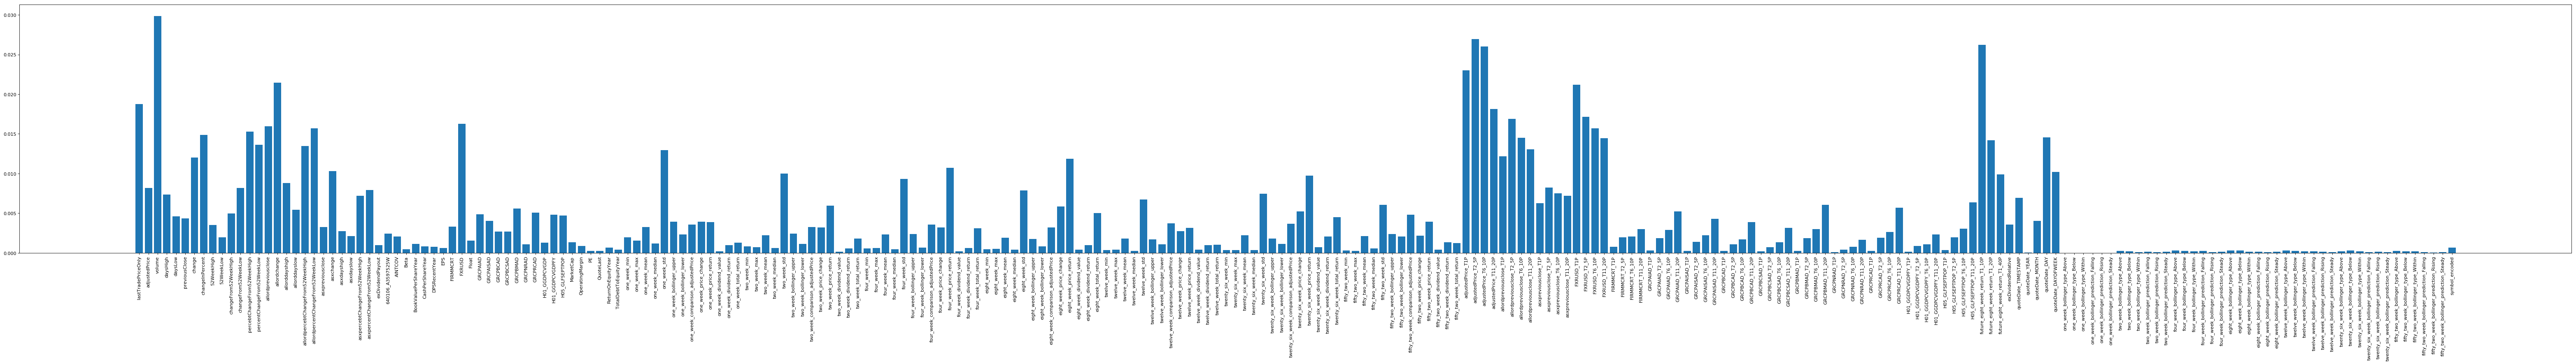

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import plot_importance

baseline_columns = df_pp_train_x.columns.values
plt.figure(num=None, figsize=(100, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(range(len(baseline_model.feature_importances_)), baseline_model.feature_importances_)
plt.xticks(range(len(baseline_model.feature_importances_)), baseline_columns, rotation='vertical');

## TSFresh

In [161]:
ALL_PREVIOUS_COLUMNS = []
ALL_PREVIOUS_COLUMNS.extend(CONTINUOUS_COLUMNS)
ALL_PREVIOUS_COLUMNS.extend(PAST_RESULTS_CONTINUOUS_COLUMNS)
ALL_PREVIOUS_COLUMNS.extend(RECURRENT_COLUMNS)
# ALL_PREVIOUS_COLUMNS.extend(ALL_TSFRESH)

# # print(ALL_PREVIOUS_COLUMNS)

mask = np.isin(df_augmented_train_x.columns.values, ALL_PREVIOUS_COLUMNS)
# print(mask)

OTHER_COLS = df_augmented_train_x.columns[~mask].values
OTHER_COLS

# df_augmented_train_x.isnull().sum() #.any()
# df_augmented_train_x[ALL_TSFRESH].isnull().sum() #.any()
df_augmented_train_x[TSFRESH_RELEVANT].isnull().sum() #.any()
# df_augmented_train_x[OTHER_COLS].isnull().sum() #.any()
# df_augmented_train_x[CONTINUOUS_COLUMNS].isnull().sum() #.any()
# df_augmented_train_x[PAST_RESULTS_CONTINUOUS_COLUMNS].isnull().sum() #.any()
# df_augmented_train_x[RECURRENT_COLUMNS].isnull().sum() #.any()


value__abs_energy                                                        0
value__absolute_sum_of_changes                                           0
value__agg_autocorrelation__f_agg_"mean"                                 0
value__agg_autocorrelation__f_agg_"median"                               0
value__agg_autocorrelation__f_agg_"var"                                  0
value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"     0
value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"        0
value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"         0
value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"        0
value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"      0
value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"         0
value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"          0
value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"         0
value__agg_linear_trend__

In [160]:
# df_augmented_train_x[ALL_TSFRESH] = df_augmented_train_x[ALL_TSFRESH].fillna(0)

df_augmented_train_x[TSFRESH_RELEVANT] = df_augmented_train_x[TSFRESH_RELEVANT].fillna(0)

In [162]:
from ensemble_processing import execute_preprocessor
from processing_constants import LABEL_COLUMN
from processing_constants import CONTINUOUS_COLUMNS, PAST_RESULTS_CONTINUOUS_COLUMNS
from processing_constants import CATEGORICAL_COLUMNS, PAST_RESULTS_CATEGORICAL_COLUMNS
from processing_constants import COLUMNS_TO_REMOVE, RECURRENT_COLUMNS


return_col = 'future_eight_week_return'
train_y_augmented_values = df_augmented_train_x[return_col].values
aug_train_x = df_augmented_train_x.drop([return_col], axis=1, errors='ignore')

aug_train_x['exDividendRelative'] = aug_train_x['exDividendDate'] - aug_train_x['quoteDate']

# convert string difference value to integer
aug_train_x['exDividendRelative'] = aug_train_x['exDividendRelative'].apply(
    lambda x: np.nan if pd.isnull(x) else x.days)
# Make sure it is the minimum data type size
aug_train_x.loc[:, 'exDividendRelative'] = aug_train_x['exDividendRelative'].astype('int32', errors='ignore')

aug_train_x['quoteDate_TIMESTAMP'] = (pd.DatetimeIndex(aug_train_x['quoteDate']) - 
                                      pd.datetime(2007, 1, 1)).total_seconds()
aug_train_x['quoteDate_TIMESTAMP'] = aug_train_x['quoteDate_TIMESTAMP'].astype('int32', errors='ignore')
aug_train_x['quoteDate_YEAR'] = pd.DatetimeIndex(aug_train_x['quoteDate']).year.astype('str')
aug_train_x['quoteDate_YEAR'] = aug_train_x['quoteDate_YEAR'].astype('int32', errors='ignore')
aug_train_x['quoteDate_MONTH'] = pd.DatetimeIndex(aug_train_x['quoteDate']).month.astype('str')
aug_train_x['quoteDate_MONTH'] = aug_train_x['quoteDate_MONTH'].astype('int32', errors='ignore')
aug_train_x['quoteDate_DAY'] = pd.DatetimeIndex(aug_train_x['quoteDate']).day.astype('str')
aug_train_x['quoteDate_DAY'] = aug_train_x['quoteDate_DAY'].astype('int32', errors='ignore')
aug_train_x['quoteDate_DAYOFWEEK'] = pd.DatetimeIndex(aug_train_x['quoteDate']).dayofweek.astype('str')
aug_train_x['quoteDate_DAYOFWEEK'] = aug_train_x['quoteDate_DAYOFWEEK'].astype('int32', errors='ignore')

aug_train_x.drop(['quoteDate', 'exDividendDate'], axis=1, inplace=True)


aug_train_x.drop(['GICSSector', 'GICSIndustryGroup', 'GICSIndustry', 'one_week_comparison_date',
                  'two_week_comparison_date', 'four_week_comparison_date',
                  'eight_week_comparison_date', 'twelve_week_comparison_date',
                  'twenty_six_week_comparison_date', 'fifty_two_week_comparison_date'], 
                 axis=1, inplace=True)

symbol_encoder = load('../models/se.pkl.gz')
imputer = load('../models/imputer.pkl.gz')
scaler = load('../models/scaler.pkl.gz')

print('Executing pre-processing')
# Execute pre-processing
df_pp_augmented_train_x = execute_preprocessor(aug_train_x, symbol_encoder, imputer, scaler)

Executing pre-processing
Executing pre-processor on supplied data...
One hot encoding past results categorical columns
Encoding symbol values
Merging encoded symbol with dataframe
Dropping symbol column
Imputing missing values
Executing imputer
-- continuous columns
-- past results continous columns
-- recurrent columns
Remove any remaining columns with nan values
Scaling data...
Executing scaler
-- continuous columns
-- past results continuous columns
-- recurrent columns
-- categorical columns


In [163]:
aug_train_x.describe()

52WeekHigh     52WeekLow  640106_A3597525W       AINTCOV        Beta  \
count  18275.000000  18273.000000      10800.000000  9.190000e+03  907.000000   
mean      40.229813     30.857351        105.736855 -6.378773e+04    0.374421   
std       74.174255     59.839161          3.948403  3.510314e+05    0.847663   
min        0.002000      0.000000         99.199997 -1.944798e+06   -0.670000   
25%        0.231000      0.042000        102.000000 -3.102200e+02   -0.390000   
50%        1.184200      0.573400        106.400002  5.281000e+01    0.270000   
75%       42.200001     33.900002        108.599998  5.870000e+01    0.790000   
max      364.480011    305.790009        112.599998  1.515370e+05    2.320000   

       BookValuePerShareYear  CashPerShareYear  DPSRecentYear          EPS  \
count            8623.000000       8623.000000   10785.000000  8623.000000   
mean               15.122164          0.043146       0.281459    41.436920   
std                45.700779          0.228420       0.883705   425.729248   
min                -0.020000         -0.006000       0.000000  -910.400024   
25%                 0.000000         -0.001000       0.000000    -1.500000   
50%                 0.000000          0.000000       0.000000    -0.200000   
75%                 0.020000          0.000000       0.092858    -0.100000   
max               272.299988          1.250000       6.047000  3348.399902   

           FIRMMCRT  FIRMMCRT_T11_20P  FIRMMCRT_T1P  FIRMMCRT_T2_5P  \
count  18275.000000      18165.000000  18265.000000    18255.000000   
mean       3.508551         -0.009981     -0.000649       -0.002307   
std        1.695613          0.045119      0.011263        0.020376   
min        1.500000         -0.381257     -0.368421       -0.368421   
25%        2.000000          0.000000      0.000000        0.000000   
50%        3.000062          0.000000      0.000000        0.000000   
75%        4.500000          0.000000      0.000000        0.000000   
max        7.250017          0.162963      0.081482        0.081482   

       FIRMMCRT_T6_10P        FXRUSD  FXRUSD_T11_20P    FXRUSD_T1P  \
count     18215.000000  18275.000000    18165.000000  18265.000000   
mean         -0.005191      0.874186       -0.000818     -0.000032   
std           0.031820      0.115407        0.035969      0.009723   
min          -0.368421      0.612200       -0.247727     -0.084268   
25%           0.000000      0.767500       -0.018509     -0.004886   
50%           0.000000      0.888100        0.001193      0.000104   
75%           0.000000      0.961700        0.019518      0.005077   
max           0.162963      1.105500        0.223213      0.112017   

       FXRUSD_T2_5P  FXRUSD_T6_10P         Float      GRCPAIAD  \
count  18255.000000   18215.000000  8.992000e+03  18275.000000   
mean      -0.000237      -0.000439  8.944069e+08    116.988274   
std        0.016467       0.025731  9.107157e+08     18.671335   
min       -0.166115      -0.216950  2.000000e+00     83.584297   
25%       -0.008248      -0.013545  7.690630e+07    100.394608   
50%        0.000383       0.001011  6.219000e+08    118.360847   
75%        0.008606       0.014736  1.882700e+09    130.888748   
max        0.175038       0.195494  2.339400e+09    168.644928   

       GRCPAIAD_T11_20P  GRCPAIAD_T1P  GRCPAIAD_T2_5P  GRCPAIAD_T6_10P  \
count      18165.000000  18265.000000    18255.000000     18215.000000   
mean           0.001833      0.000109        0.000357         0.000920   
std            0.047719      0.011954        0.021561         0.034026   
min           -0.266544     -0.244995       -0.266544        -0.266544   
25%           -0.017857      0.000000        0.000000         0.000000   
50%            0.000000      0.000000        0.000000         0.000000   
75%            0.022129      0.000000        0.000000         0.000000   
max            0.410887      0.399710        0.399710         0.410887   

          GRCPAISAD  GRCPAISAD_T11_20P  GRC

In [99]:
len(train_y_augmented_values)

18275

In [164]:
df_pp_augmented_train_x.describe()

52WeekHigh     52WeekLow  640106_A3597525W       AINTCOV  \
count  1.827500e+04  18275.000000      18275.000000  18275.000000   
mean   1.117529e-05      0.003673          0.514253      0.570583   
std    2.060464e-05      0.007123          0.228712      0.061884   
min    5.555561e-10      0.000000          0.000000      0.098913   
25%    6.416673e-08      0.000005          0.462687      0.578548   
50%    3.289448e-07      0.000068          0.552239      0.578548   
75%    1.172223e-05      0.004036          0.567165      0.578559   
max    1.012445e-04      0.036404          1.000000      0.615919   

               Beta  BookValuePerShareYear  CashPerShareYear  DPSRecentYear  \
count  18275.000000           18275.000000      18275.000000   18275.000000   
mean       0.568338               0.103288          0.865339       0.000232   
std        0.012213               0.042312          0.000357       0.000969   
min        0.483668               0.093841          0.865442       0.000000   
25%        0.569627               0.093867          0.865454       0.000000   
50%        0.569627               0.093985          0.865454       0.000000   
75%        0.569627               0.093985          0.865454       0.000000   
max        0.655014               0.450851          0.867990       0.008456   

                EPS      FIRMMCRT  FIRMMCRT_T11_20P  FIRMMCRT_T1P  \
count  18275.000000  18275.000000      18275.000000  18275.000000   
mean       0.408625      0.349309          0.568972      0.553291   
std        0.016182      0.294886          0.032688      0.008611   
min        0.357241      0.000000          0.299212      0.272065   
25%        0.407474      0.086956          0.576201      0.553846   
50%        0.407479      0.260880          0.576201      0.553846   
75%        0.407479      0.521738          0.576201      0.553846   
max        0.592278      1.000000          0.694595      0.616166   

       FIRMMCRT_T2_5P  FIRMMCRT_T6_10P        FXRUSD  FXRUSD_T11_20P  \
count    18275.000000     18275.000000  18275.000000    18275.000000   
mean         0.559418         0.572417      0.531084        0.348167   
std          0.015322         0.023081      0.233948        0.034394   
min          0.283953         0.308538      0.000000        0.111342   
25%          0.561133         0.576201      0.314819        0.331271   
50%          0.561133         0.576201      0.559295        0.350022   
75%          0.561133         0.576201      0.708494        0.367627   
max          0.622435         0.694595      1.000000        0.563026   

         FXRUSD_T1P  FXRUSD_T2_5P  FXRUSD_T6_10P         Float      GRCPAIAD  \
count  18275.000000  18275.000000   18275.000000  1.827500e+04  18275.000000   
mean       0.332786      0.343609       0.336297  4.079470e-02      0.392705   
std        0.009307      0.015789       0.023699  5.315984e-02      0.219508   
min        0.252130      0.184478       0.136559  1.473568e-10      0.000000   
25%        0.328142      0.335947       0.324251  1.647449e-02      0.197627   
50%        0.332916      0.344201       0.337691  1.647449e-02      0.408844   
75%        0.337663      0.352087       0.350252  4.582059e-02      0.556126   
max        0.440073      0.511754       0.517043  1.723632e-01      1.000000   

       GRCPAIAD_T11_20P  GRCPAIAD_T1P  GRCPAIAD_T2_5P  GRCPAIAD_T6_10P  \
count      18275.000000  18275.000000    18275.000000     18275.000000   
mean           0.358966      0.413783        0.367002         0.352304   
std            0.039070      0.011418        0.018248         0.027439   
min            0.138580      0.179661        0.140993         0.136293   
25%            0.342809      0.413726        0.366704         0.351574   
50%            0.357473      0.413726        0.366704         0.351574   
75%            0.375504      0.413726        0.366704         0.351574   
max            0.694904      0.795604        0.705181         0.683436   

          GRCPAI

In [91]:
df_pp_augmented_train_x.dtypes


lastTradePriceOnly                                                       float32
adjustedPrice                                                            float32
volume                                                                   float32
daysHigh                                                                 float32
daysLow                                                                  float32
previousClose                                                            float32
change                                                                   float32
changeInPercent                                                          float32
52WeekHigh                                                               float32
52WeekLow                                                                float32
changeFrom52WeekHigh                                                     float32
changeFrom52WeekLow                                                      float32
percebtChangeFrom52WeekHigh 

In [168]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

augmented_model = xgb.XGBRegressor(nthread=8, tree_method='auto', predictor='cpu_predictor', 
                                   n_estimators=250, max_depth=70, base_score=0.1, 
                                   colsample_bylevel=0.7, colsample_bytree=1.0, 
                                   gamma=0, learning_rate=0.05, min_child_weight=3)


print('Training xgboost baseline model...')
x_train, x_test, y_train, y_test = train_test_split(df_pp_augmented_train_x.values, 
                                                    train_y_augmented_values, test_size=0.15)

eval_set = [(x_test, y_test)]
augmented_model.fit(x_train, y_train, early_stopping_rounds=25, eval_metric='mae', eval_set=eval_set, verbose=True)

Training xgboost baseline model...
[0]	validation_0-mae:22.8414
Will train until validation_0-mae hasn't improved in 25 rounds.
[1]	validation_0-mae:22.0687
[2]	validation_0-mae:21.3808
[3]	validation_0-mae:20.731
[4]	validation_0-mae:20.1066
[5]	validation_0-mae:19.4773
[6]	validation_0-mae:18.8733
[7]	validation_0-mae:18.2832
[8]	validation_0-mae:17.7934
[9]	validation_0-mae:17.3249
[10]	validation_0-mae:16.8591
[11]	validation_0-mae:16.4461
[12]	validation_0-mae:16.0439
[13]	validation_0-mae:15.6684
[14]	validation_0-mae:15.328
[15]	validation_0-mae:14.9768
[16]	validation_0-mae:14.676
[17]	validation_0-mae:14.3776
[18]	validation_0-mae:14.1222
[19]	validation_0-mae:13.8492
[20]	validation_0-mae:13.5866
[21]	validation_0-mae:13.352
[22]	validation_0-mae:13.136
[23]	validation_0-mae:12.9244
[24]	validation_0-mae:12.7471
[25]	validation_0-mae:12.5564
[26]	validation_0-mae:12.394
[27]	validation_0-mae:12.2549
[28]	validation_0-mae:12.0987
[29]	validation_0-mae:11.9636
[30]	validation_0

XGBRegressor(base_score=0.1, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=70, min_child_weight=3, missing=None, n_estimators=250,
       n_jobs=1, nthread=8, objective='reg:linear',
       predictor='cpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='auto')

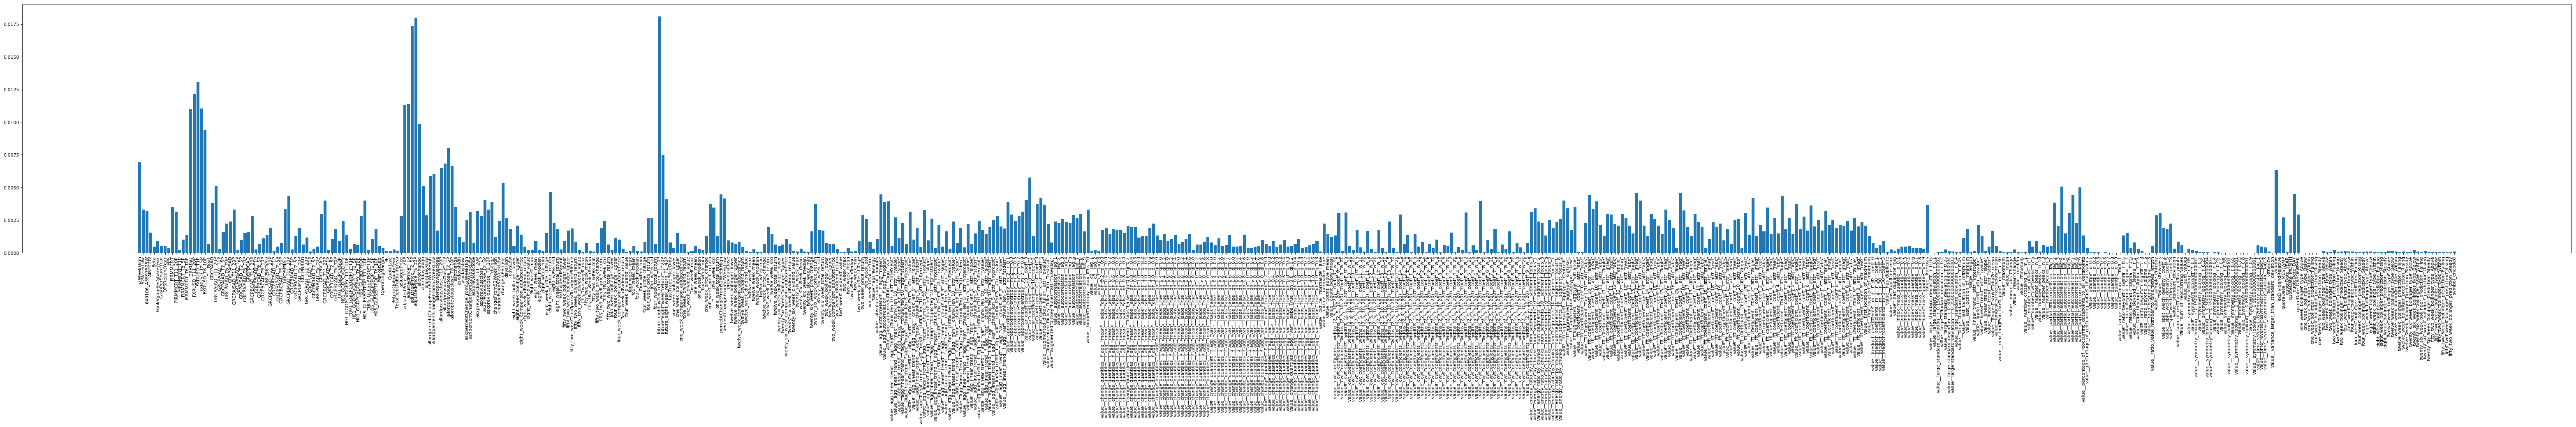

In [171]:
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import plot_importance

augmented_columns = df_pp_augmented_train_x.columns.values
plt.figure(num=None, figsize=(100, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(range(len(augmented_model.feature_importances_)), augmented_model.feature_importances_)
plt.xticks(range(len(augmented_model.feature_importances_)), augmented_columns, rotation='vertical');

In [172]:
augmented_columns

array(['52WeekHigh', '52WeekLow', '640106_A3597525W', 'AINTCOV', 'Beta',
       'BookValuePerShareYear', 'CashPerShareYear', 'DPSRecentYear',
       'EPS', 'FIRMMCRT', 'FIRMMCRT_T11_20P', 'FIRMMCRT_T1P',
       'FIRMMCRT_T2_5P', 'FIRMMCRT_T6_10P', 'FXRUSD', 'FXRUSD_T11_20P',
       'FXRUSD_T1P', 'FXRUSD_T2_5P', 'FXRUSD_T6_10P', 'Float', 'GRCPAIAD',
       'GRCPAIAD_T11_20P', 'GRCPAIAD_T1P', 'GRCPAIAD_T2_5P',
       'GRCPAIAD_T6_10P', 'GRCPAISAD', 'GRCPAISAD_T11_20P',
       'GRCPAISAD_T1P', 'GRCPAISAD_T2_5P', 'GRCPAISAD_T6_10P', 'GRCPBCAD',
       'GRCPBCAD_T11_20P', 'GRCPBCAD_T1P', 'GRCPBCAD_T2_5P',
       'GRCPBCAD_T6_10P', 'GRCPBCSAD', 'GRCPBCSAD_T11_20P',
       'GRCPBCSAD_T1P', 'GRCPBCSAD_T2_5P', 'GRCPBCSAD_T6_10P', 'GRCPBMAD',
       'GRCPBMAD_T11_20P', 'GRCPBMAD_T1P', 'GRCPBMAD_T2_5P',
       'GRCPBMAD_T6_10P', 'GRCPNRAD', 'GRCPNRAD_T11_20P', 'GRCPNRAD_T1P',
       'GRCPNRAD_T2_5P', 'GRCPNRAD_T6_10P', 'GRCPRCAD',
       'GRCPRCAD_T11_20P', 'GRCPRCAD_T1P', 'GRCPRCAD_T2_5P',
     

## Big stuff

In [116]:
ALL_TSFRESH = ['value__abs_energy', 'value__absolute_sum_of_changes',
       'value__agg_autocorrelation__f_agg_"mean"',
       'value__agg_autocorrelation__f_agg_"median"',
       'value__agg_autocorrelation__f_agg_"var"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"slope"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"slope"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"slope"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"slope"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"slope"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"slope"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"stderr"',
       'value__approximate_entropy__m_2__r_0.1',
       'value__approximate_entropy__m_2__r_0.3',
       'value__approximate_entropy__m_2__r_0.5',
       'value__approximate_entropy__m_2__r_0.7',
       'value__approximate_entropy__m_2__r_0.9',
       'value__ar_coefficient__k_10__coeff_0',
       'value__ar_coefficient__k_10__coeff_1',
       'value__ar_coefficient__k_10__coeff_2',
       'value__ar_coefficient__k_10__coeff_3',
       'value__ar_coefficient__k_10__coeff_4',
       'value__augmented_dickey_fuller__attr_"pvalue"',
       'value__augmented_dickey_fuller__attr_"teststat"',
       'value__augmented_dickey_fuller__attr_"usedlag"',
       'value__autocorrelation__lag_0', 'value__autocorrelation__lag_1',
       'value__autocorrelation__lag_2', 'value__autocorrelation__lag_3',
       'value__autocorrelation__lag_4', 'value__autocorrelation__lag_5',
       'value__autocorrelation__lag_6', 'value__autocorrelation__lag_7',
       'value__autocorrelation__lag_8', 'value__autocorrelation__lag_9',
       'value__binned_entropy__max_bins_10', 'value__c3__lag_1',
       'value__c3__lag_2', 'value__c3__lag_3',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
       'value__cid_ce__normalize_False', 'value__cid_ce__normalize_True',
       'value__count_above_mean', 'value__count_below_mean',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_5',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_0',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_1',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_2',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_3',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_4',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_5',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_6',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_7',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_8',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
       'value__fft_aggregated__aggtype_"centroid"',
       'value__fft_aggregated__aggtype_"kurtosis"',
       'value__fft_aggregated__aggtype_"skew"',
       'value__fft_aggregated__aggtype_"variance"',
       'value__fft_coefficient__coeff_0__attr_"abs"',
       'value__fft_coefficient__coeff_0__attr_"angle"',
       'value__fft_coefficient__coeff_0__attr_"imag"',
       'value__fft_coefficient__coeff_0__attr_"real"',
       'value__fft_coefficient__coeff_10__attr_"abs"',
       'value__fft_coefficient__coeff_10__attr_"angle"',
       'value__fft_coefficient__coeff_10__attr_"imag"',
       'value__fft_coefficient__coeff_10__attr_"real"',
       'value__fft_coefficient__coeff_11__attr_"abs"',
       'value__fft_coefficient__coeff_11__attr_"angle"',
       'value__fft_coefficient__coeff_11__attr_"imag"',
       'value__fft_coefficient__coeff_11__attr_"real"',
       'value__fft_coefficient__coeff_12__attr_"abs"',
       'value__fft_coefficient__coeff_12__attr_"angle"',
       'value__fft_coefficient__coeff_12__attr_"imag"',
       'value__fft_coefficient__coeff_12__attr_"real"',
       'value__fft_coefficient__coeff_13__attr_"abs"',
       'value__fft_coefficient__coeff_13__attr_"angle"',
       'value__fft_coefficient__coeff_13__attr_"imag"',
       'value__fft_coefficient__coeff_13__attr_"real"',
       'value__fft_coefficient__coeff_14__attr_"abs"',
       'value__fft_coefficient__coeff_14__attr_"angle"',
       'value__fft_coefficient__coeff_14__attr_"imag"',
       'value__fft_coefficient__coeff_14__attr_"real"',
       'value__fft_coefficient__coeff_15__attr_"abs"',
       'value__fft_coefficient__coeff_15__attr_"angle"',
       'value__fft_coefficient__coeff_15__attr_"imag"',
       'value__fft_coefficient__coeff_15__attr_"real"',
       'value__fft_coefficient__coeff_16__attr_"abs"',
       'value__fft_coefficient__coeff_16__attr_"angle"',
       'value__fft_coefficient__coeff_16__attr_"imag"',
       'value__fft_coefficient__coeff_16__attr_"real"',
       'value__fft_coefficient__coeff_17__attr_"abs"',
       'value__fft_coefficient__coeff_17__attr_"angle"',
       'value__fft_coefficient__coeff_17__attr_"imag"',
       'value__fft_coefficient__coeff_17__attr_"real"',
       'value__fft_coefficient__coeff_18__attr_"abs"',
       'value__fft_coefficient__coeff_18__attr_"angle"',
       'value__fft_coefficient__coeff_18__attr_"imag"',
       'value__fft_coefficient__coeff_18__attr_"real"',
       'value__fft_coefficient__coeff_19__attr_"abs"',
       'value__fft_coefficient__coeff_19__attr_"angle"',
       'value__fft_coefficient__coeff_19__attr_"imag"',
       'value__fft_coefficient__coeff_19__attr_"real"',
       'value__fft_coefficient__coeff_1__attr_"abs"',
       'value__fft_coefficient__coeff_1__attr_"angle"',
       'value__fft_coefficient__coeff_1__attr_"imag"',
       'value__fft_coefficient__coeff_1__attr_"real"',
       'value__fft_coefficient__coeff_20__attr_"abs"',
       'value__fft_coefficient__coeff_20__attr_"angle"',
       'value__fft_coefficient__coeff_20__attr_"imag"',
       'value__fft_coefficient__coeff_20__attr_"real"',
       'value__fft_coefficient__coeff_21__attr_"abs"',
       'value__fft_coefficient__coeff_21__attr_"angle"',
       'value__fft_coefficient__coeff_21__attr_"imag"',
       'value__fft_coefficient__coeff_21__attr_"real"',
       'value__fft_coefficient__coeff_22__attr_"abs"',
       'value__fft_coefficient__coeff_22__attr_"angle"',
       'value__fft_coefficient__coeff_22__attr_"imag"',
       'value__fft_coefficient__coeff_22__attr_"real"',
       'value__fft_coefficient__coeff_23__attr_"abs"',
       'value__fft_coefficient__coeff_23__attr_"angle"',
       'value__fft_coefficient__coeff_23__attr_"imag"',
       'value__fft_coefficient__coeff_23__attr_"real"',
       'value__fft_coefficient__coeff_24__attr_"abs"',
       'value__fft_coefficient__coeff_24__attr_"angle"',
       'value__fft_coefficient__coeff_24__attr_"imag"',
       'value__fft_coefficient__coeff_24__attr_"real"',
       'value__fft_coefficient__coeff_25__attr_"abs"',
       'value__fft_coefficient__coeff_25__attr_"angle"',
       'value__fft_coefficient__coeff_25__attr_"imag"',
       'value__fft_coefficient__coeff_25__attr_"real"',
       'value__fft_coefficient__coeff_26__attr_"abs"',
       'value__fft_coefficient__coeff_26__attr_"angle"',
       'value__fft_coefficient__coeff_26__attr_"imag"',
       'value__fft_coefficient__coeff_26__attr_"real"',
       'value__fft_coefficient__coeff_27__attr_"abs"',
       'value__fft_coefficient__coeff_27__attr_"angle"',
       'value__fft_coefficient__coeff_27__attr_"imag"',
       'value__fft_coefficient__coeff_27__attr_"real"',
       'value__fft_coefficient__coeff_28__attr_"abs"',
       'value__fft_coefficient__coeff_28__attr_"angle"',
       'value__fft_coefficient__coeff_28__attr_"imag"',
       'value__fft_coefficient__coeff_28__attr_"real"',
       'value__fft_coefficient__coeff_29__attr_"abs"',
       'value__fft_coefficient__coeff_29__attr_"angle"',
       'value__fft_coefficient__coeff_29__attr_"imag"',
       'value__fft_coefficient__coeff_29__attr_"real"',
       'value__fft_coefficient__coeff_2__attr_"abs"',
       'value__fft_coefficient__coeff_2__attr_"angle"',
       'value__fft_coefficient__coeff_2__attr_"imag"',
       'value__fft_coefficient__coeff_2__attr_"real"',
       'value__fft_coefficient__coeff_30__attr_"abs"',
       'value__fft_coefficient__coeff_30__attr_"angle"',
       'value__fft_coefficient__coeff_30__attr_"imag"',
       'value__fft_coefficient__coeff_30__attr_"real"',
       'value__fft_coefficient__coeff_31__attr_"abs"',
       'value__fft_coefficient__coeff_31__attr_"angle"',
       'value__fft_coefficient__coeff_31__attr_"imag"',
       'value__fft_coefficient__coeff_31__attr_"real"',
       'value__fft_coefficient__coeff_32__attr_"abs"',
       'value__fft_coefficient__coeff_32__attr_"angle"',
       'value__fft_coefficient__coeff_32__attr_"imag"',
       'value__fft_coefficient__coeff_32__attr_"real"',
       'value__fft_coefficient__coeff_33__attr_"abs"',
       'value__fft_coefficient__coeff_33__attr_"angle"',
       'value__fft_coefficient__coeff_33__attr_"imag"',
       'value__fft_coefficient__coeff_33__attr_"real"',
       'value__fft_coefficient__coeff_34__attr_"abs"',
       'value__fft_coefficient__coeff_34__attr_"angle"',
       'value__fft_coefficient__coeff_34__attr_"imag"',
       'value__fft_coefficient__coeff_34__attr_"real"',
       'value__fft_coefficient__coeff_35__attr_"abs"',
       'value__fft_coefficient__coeff_35__attr_"angle"',
       'value__fft_coefficient__coeff_35__attr_"imag"',
       'value__fft_coefficient__coeff_35__attr_"real"',
       'value__fft_coefficient__coeff_36__attr_"abs"',
       'value__fft_coefficient__coeff_36__attr_"angle"',
       'value__fft_coefficient__coeff_36__attr_"imag"',
       'value__fft_coefficient__coeff_36__attr_"real"',
       'value__fft_coefficient__coeff_37__attr_"abs"',
       'value__fft_coefficient__coeff_37__attr_"angle"',
       'value__fft_coefficient__coeff_37__attr_"imag"',
       'value__fft_coefficient__coeff_37__attr_"real"',
       'value__fft_coefficient__coeff_38__attr_"abs"',
       'value__fft_coefficient__coeff_38__attr_"angle"',
       'value__fft_coefficient__coeff_38__attr_"imag"',
       'value__fft_coefficient__coeff_38__attr_"real"',
       'value__fft_coefficient__coeff_39__attr_"abs"',
       'value__fft_coefficient__coeff_39__attr_"angle"',
       'value__fft_coefficient__coeff_39__attr_"imag"',
       'value__fft_coefficient__coeff_39__attr_"real"',
       'value__fft_coefficient__coeff_3__attr_"abs"',
       'value__fft_coefficient__coeff_3__attr_"angle"',
       'value__fft_coefficient__coeff_3__attr_"imag"',
       'value__fft_coefficient__coeff_3__attr_"real"',
       'value__fft_coefficient__coeff_40__attr_"abs"',
       'value__fft_coefficient__coeff_40__attr_"angle"',
       'value__fft_coefficient__coeff_40__attr_"imag"',
       'value__fft_coefficient__coeff_40__attr_"real"',
       'value__fft_coefficient__coeff_41__attr_"abs"',
       'value__fft_coefficient__coeff_41__attr_"angle"',
       'value__fft_coefficient__coeff_41__attr_"imag"',
       'value__fft_coefficient__coeff_41__attr_"real"',
       'value__fft_coefficient__coeff_42__attr_"abs"',
       'value__fft_coefficient__coeff_42__attr_"angle"',
       'value__fft_coefficient__coeff_42__attr_"imag"',
       'value__fft_coefficient__coeff_42__attr_"real"',
       'value__fft_coefficient__coeff_43__attr_"abs"',
       'value__fft_coefficient__coeff_43__attr_"angle"',
       'value__fft_coefficient__coeff_43__attr_"imag"',
       'value__fft_coefficient__coeff_43__attr_"real"',
       'value__fft_coefficient__coeff_44__attr_"abs"',
       'value__fft_coefficient__coeff_44__attr_"angle"',
       'value__fft_coefficient__coeff_44__attr_"imag"',
       'value__fft_coefficient__coeff_44__attr_"real"',
       'value__fft_coefficient__coeff_45__attr_"abs"',
       'value__fft_coefficient__coeff_45__attr_"angle"',
       'value__fft_coefficient__coeff_45__attr_"imag"',
       'value__fft_coefficient__coeff_45__attr_"real"',
       'value__fft_coefficient__coeff_46__attr_"abs"',
       'value__fft_coefficient__coeff_46__attr_"angle"',
       'value__fft_coefficient__coeff_46__attr_"imag"',
       'value__fft_coefficient__coeff_46__attr_"real"',
       'value__fft_coefficient__coeff_47__attr_"abs"',
       'value__fft_coefficient__coeff_47__attr_"angle"',
       'value__fft_coefficient__coeff_47__attr_"imag"',
       'value__fft_coefficient__coeff_47__attr_"real"',
       'value__fft_coefficient__coeff_48__attr_"abs"',
       'value__fft_coefficient__coeff_48__attr_"angle"',
       'value__fft_coefficient__coeff_48__attr_"imag"',
       'value__fft_coefficient__coeff_48__attr_"real"',
       'value__fft_coefficient__coeff_49__attr_"abs"',
       'value__fft_coefficient__coeff_49__attr_"angle"',
       'value__fft_coefficient__coeff_49__attr_"imag"',
       'value__fft_coefficient__coeff_49__attr_"real"',
       'value__fft_coefficient__coeff_4__attr_"abs"',
       'value__fft_coefficient__coeff_4__attr_"angle"',
       'value__fft_coefficient__coeff_4__attr_"imag"',
       'value__fft_coefficient__coeff_4__attr_"real"',
       'value__fft_coefficient__coeff_50__attr_"abs"',
       'value__fft_coefficient__coeff_50__attr_"angle"',
       'value__fft_coefficient__coeff_50__attr_"imag"',
       'value__fft_coefficient__coeff_50__attr_"real"',
       'value__fft_coefficient__coeff_51__attr_"abs"',
       'value__fft_coefficient__coeff_51__attr_"angle"',
       'value__fft_coefficient__coeff_51__attr_"imag"',
       'value__fft_coefficient__coeff_51__attr_"real"',
       'value__fft_coefficient__coeff_52__attr_"abs"',
       'value__fft_coefficient__coeff_52__attr_"angle"',
       'value__fft_coefficient__coeff_52__attr_"imag"',
       'value__fft_coefficient__coeff_52__attr_"real"',
       'value__fft_coefficient__coeff_53__attr_"abs"',
       'value__fft_coefficient__coeff_53__attr_"angle"',
       'value__fft_coefficient__coeff_53__attr_"imag"',
       'value__fft_coefficient__coeff_53__attr_"real"',
       'value__fft_coefficient__coeff_54__attr_"abs"',
       'value__fft_coefficient__coeff_54__attr_"angle"',
       'value__fft_coefficient__coeff_54__attr_"imag"',
       'value__fft_coefficient__coeff_54__attr_"real"',
       'value__fft_coefficient__coeff_55__attr_"abs"',
       'value__fft_coefficient__coeff_55__attr_"angle"',
       'value__fft_coefficient__coeff_55__attr_"imag"',
       'value__fft_coefficient__coeff_55__attr_"real"',
       'value__fft_coefficient__coeff_56__attr_"abs"',
       'value__fft_coefficient__coeff_56__attr_"angle"',
       'value__fft_coefficient__coeff_56__attr_"imag"',
       'value__fft_coefficient__coeff_56__attr_"real"',
       'value__fft_coefficient__coeff_57__attr_"abs"',
       'value__fft_coefficient__coeff_57__attr_"angle"',
       'value__fft_coefficient__coeff_57__attr_"imag"',
       'value__fft_coefficient__coeff_57__attr_"real"',
       'value__fft_coefficient__coeff_58__attr_"abs"',
       'value__fft_coefficient__coeff_58__attr_"angle"',
       'value__fft_coefficient__coeff_58__attr_"imag"',
       'value__fft_coefficient__coeff_58__attr_"real"',
       'value__fft_coefficient__coeff_59__attr_"abs"',
       'value__fft_coefficient__coeff_59__attr_"angle"',
       'value__fft_coefficient__coeff_59__attr_"imag"',
       'value__fft_coefficient__coeff_59__attr_"real"',
       'value__fft_coefficient__coeff_5__attr_"abs"',
       'value__fft_coefficient__coeff_5__attr_"angle"',
       'value__fft_coefficient__coeff_5__attr_"imag"',
       'value__fft_coefficient__coeff_5__attr_"real"',
       'value__fft_coefficient__coeff_60__attr_"abs"',
       'value__fft_coefficient__coeff_60__attr_"angle"',
       'value__fft_coefficient__coeff_60__attr_"imag"',
       'value__fft_coefficient__coeff_60__attr_"real"',
       'value__fft_coefficient__coeff_61__attr_"abs"',
       'value__fft_coefficient__coeff_61__attr_"angle"',
       'value__fft_coefficient__coeff_61__attr_"imag"',
       'value__fft_coefficient__coeff_61__attr_"real"',
       'value__fft_coefficient__coeff_62__attr_"abs"',
       'value__fft_coefficient__coeff_62__attr_"angle"',
       'value__fft_coefficient__coeff_62__attr_"imag"',
       'value__fft_coefficient__coeff_62__attr_"real"',
       'value__fft_coefficient__coeff_63__attr_"abs"',
       'value__fft_coefficient__coeff_63__attr_"angle"',
       'value__fft_coefficient__coeff_63__attr_"imag"',
       'value__fft_coefficient__coeff_63__attr_"real"',
       'value__fft_coefficient__coeff_64__attr_"abs"',
       'value__fft_coefficient__coeff_64__attr_"angle"',
       'value__fft_coefficient__coeff_64__attr_"imag"',
       'value__fft_coefficient__coeff_64__attr_"real"',
       'value__fft_coefficient__coeff_65__attr_"abs"',
       'value__fft_coefficient__coeff_65__attr_"angle"',
       'value__fft_coefficient__coeff_65__attr_"imag"',
       'value__fft_coefficient__coeff_65__attr_"real"',
       'value__fft_coefficient__coeff_66__attr_"abs"',
       'value__fft_coefficient__coeff_66__attr_"angle"',
       'value__fft_coefficient__coeff_66__attr_"imag"',
       'value__fft_coefficient__coeff_66__attr_"real"',
       'value__fft_coefficient__coeff_67__attr_"abs"',
       'value__fft_coefficient__coeff_67__attr_"angle"',
       'value__fft_coefficient__coeff_67__attr_"imag"',
       'value__fft_coefficient__coeff_67__attr_"real"',
       'value__fft_coefficient__coeff_68__attr_"abs"',
       'value__fft_coefficient__coeff_68__attr_"angle"',
       'value__fft_coefficient__coeff_68__attr_"imag"',
       'value__fft_coefficient__coeff_68__attr_"real"',
       'value__fft_coefficient__coeff_69__attr_"abs"',
       'value__fft_coefficient__coeff_69__attr_"angle"',
       'value__fft_coefficient__coeff_69__attr_"imag"',
       'value__fft_coefficient__coeff_69__attr_"real"',
       'value__fft_coefficient__coeff_6__attr_"abs"',
       'value__fft_coefficient__coeff_6__attr_"angle"',
       'value__fft_coefficient__coeff_6__attr_"imag"',
       'value__fft_coefficient__coeff_6__attr_"real"',
       'value__fft_coefficient__coeff_70__attr_"abs"',
       'value__fft_coefficient__coeff_70__attr_"angle"',
       'value__fft_coefficient__coeff_70__attr_"imag"',
       'value__fft_coefficient__coeff_70__attr_"real"',
       'value__fft_coefficient__coeff_71__attr_"abs"',
       'value__fft_coefficient__coeff_71__attr_"angle"',
       'value__fft_coefficient__coeff_71__attr_"imag"',
       'value__fft_coefficient__coeff_71__attr_"real"',
       'value__fft_coefficient__coeff_72__attr_"abs"',
       'value__fft_coefficient__coeff_72__attr_"angle"',
       'value__fft_coefficient__coeff_72__attr_"imag"',
       'value__fft_coefficient__coeff_72__attr_"real"',
       'value__fft_coefficient__coeff_73__attr_"abs"',
       'value__fft_coefficient__coeff_73__attr_"angle"',
       'value__fft_coefficient__coeff_73__attr_"imag"',
       'value__fft_coefficient__coeff_73__attr_"real"',
       'value__fft_coefficient__coeff_74__attr_"abs"',
       'value__fft_coefficient__coeff_74__attr_"angle"',
       'value__fft_coefficient__coeff_74__attr_"imag"',
       'value__fft_coefficient__coeff_74__attr_"real"',
       'value__fft_coefficient__coeff_75__attr_"abs"',
       'value__fft_coefficient__coeff_75__attr_"angle"',
       'value__fft_coefficient__coeff_75__attr_"imag"',
       'value__fft_coefficient__coeff_75__attr_"real"',
       'value__fft_coefficient__coeff_76__attr_"abs"',
       'value__fft_coefficient__coeff_76__attr_"angle"',
       'value__fft_coefficient__coeff_76__attr_"imag"',
       'value__fft_coefficient__coeff_76__attr_"real"',
       'value__fft_coefficient__coeff_77__attr_"abs"',
       'value__fft_coefficient__coeff_77__attr_"angle"',
       'value__fft_coefficient__coeff_77__attr_"imag"',
       'value__fft_coefficient__coeff_77__attr_"real"',
       'value__fft_coefficient__coeff_78__attr_"abs"',
       'value__fft_coefficient__coeff_78__attr_"angle"',
       'value__fft_coefficient__coeff_78__attr_"imag"',
       'value__fft_coefficient__coeff_78__attr_"real"',
       'value__fft_coefficient__coeff_79__attr_"abs"',
       'value__fft_coefficient__coeff_79__attr_"angle"',
       'value__fft_coefficient__coeff_79__attr_"imag"',
       'value__fft_coefficient__coeff_79__attr_"real"',
       'value__fft_coefficient__coeff_7__attr_"abs"',
       'value__fft_coefficient__coeff_7__attr_"angle"',
       'value__fft_coefficient__coeff_7__attr_"imag"',
       'value__fft_coefficient__coeff_7__attr_"real"',
       'value__fft_coefficient__coeff_80__attr_"abs"',
       'value__fft_coefficient__coeff_80__attr_"angle"',
       'value__fft_coefficient__coeff_80__attr_"imag"',
       'value__fft_coefficient__coeff_80__attr_"real"',
       'value__fft_coefficient__coeff_81__attr_"abs"',
       'value__fft_coefficient__coeff_81__attr_"angle"',
       'value__fft_coefficient__coeff_81__attr_"imag"',
       'value__fft_coefficient__coeff_81__attr_"real"',
       'value__fft_coefficient__coeff_82__attr_"abs"',
       'value__fft_coefficient__coeff_82__attr_"angle"',
       'value__fft_coefficient__coeff_82__attr_"imag"',
       'value__fft_coefficient__coeff_82__attr_"real"',
       'value__fft_coefficient__coeff_83__attr_"abs"',
       'value__fft_coefficient__coeff_83__attr_"angle"',
       'value__fft_coefficient__coeff_83__attr_"imag"',
       'value__fft_coefficient__coeff_83__attr_"real"',
       'value__fft_coefficient__coeff_84__attr_"abs"',
       'value__fft_coefficient__coeff_84__attr_"angle"',
       'value__fft_coefficient__coeff_84__attr_"imag"',
       'value__fft_coefficient__coeff_84__attr_"real"',
       'value__fft_coefficient__coeff_85__attr_"abs"',
       'value__fft_coefficient__coeff_85__attr_"angle"',
       'value__fft_coefficient__coeff_85__attr_"imag"',
       'value__fft_coefficient__coeff_85__attr_"real"',
       'value__fft_coefficient__coeff_86__attr_"abs"',
       'value__fft_coefficient__coeff_86__attr_"angle"',
       'value__fft_coefficient__coeff_86__attr_"imag"',
       'value__fft_coefficient__coeff_86__attr_"real"',
       'value__fft_coefficient__coeff_87__attr_"abs"',
       'value__fft_coefficient__coeff_87__attr_"angle"',
       'value__fft_coefficient__coeff_87__attr_"imag"',
       'value__fft_coefficient__coeff_87__attr_"real"',
       'value__fft_coefficient__coeff_88__attr_"abs"',
       'value__fft_coefficient__coeff_88__attr_"angle"',
       'value__fft_coefficient__coeff_88__attr_"imag"',
       'value__fft_coefficient__coeff_88__attr_"real"',
       'value__fft_coefficient__coeff_89__attr_"abs"',
       'value__fft_coefficient__coeff_89__attr_"angle"',
       'value__fft_coefficient__coeff_89__attr_"imag"',
       'value__fft_coefficient__coeff_89__attr_"real"',
       'value__fft_coefficient__coeff_8__attr_"abs"',
       'value__fft_coefficient__coeff_8__attr_"angle"',
       'value__fft_coefficient__coeff_8__attr_"imag"',
       'value__fft_coefficient__coeff_8__attr_"real"',
       'value__fft_coefficient__coeff_90__attr_"abs"',
       'value__fft_coefficient__coeff_90__attr_"angle"',
       'value__fft_coefficient__coeff_90__attr_"imag"',
       'value__fft_coefficient__coeff_90__attr_"real"',
       'value__fft_coefficient__coeff_91__attr_"abs"',
       'value__fft_coefficient__coeff_91__attr_"angle"',
       'value__fft_coefficient__coeff_91__attr_"imag"',
       'value__fft_coefficient__coeff_91__attr_"real"',
       'value__fft_coefficient__coeff_92__attr_"abs"',
       'value__fft_coefficient__coeff_92__attr_"angle"',
       'value__fft_coefficient__coeff_92__attr_"imag"',
       'value__fft_coefficient__coeff_92__attr_"real"',
       'value__fft_coefficient__coeff_93__attr_"abs"',
       'value__fft_coefficient__coeff_93__attr_"angle"',
       'value__fft_coefficient__coeff_93__attr_"imag"',
       'value__fft_coefficient__coeff_93__attr_"real"',
       'value__fft_coefficient__coeff_94__attr_"abs"',
       'value__fft_coefficient__coeff_94__attr_"angle"',
       'value__fft_coefficient__coeff_94__attr_"imag"',
       'value__fft_coefficient__coeff_94__attr_"real"',
       'value__fft_coefficient__coeff_95__attr_"abs"',
       'value__fft_coefficient__coeff_95__attr_"angle"',
       'value__fft_coefficient__coeff_95__attr_"imag"',
       'value__fft_coefficient__coeff_95__attr_"real"',
       'value__fft_coefficient__coeff_96__attr_"abs"',
       'value__fft_coefficient__coeff_96__attr_"angle"',
       'value__fft_coefficient__coeff_96__attr_"imag"',
       'value__fft_coefficient__coeff_96__attr_"real"',
       'value__fft_coefficient__coeff_97__attr_"abs"',
       'value__fft_coefficient__coeff_97__attr_"angle"',
       'value__fft_coefficient__coeff_97__attr_"imag"',
       'value__fft_coefficient__coeff_97__attr_"real"',
       'value__fft_coefficient__coeff_98__attr_"abs"',
       'value__fft_coefficient__coeff_98__attr_"angle"',
       'value__fft_coefficient__coeff_98__attr_"imag"',
       'value__fft_coefficient__coeff_98__attr_"real"',
       'value__fft_coefficient__coeff_99__attr_"abs"',
       'value__fft_coefficient__coeff_99__attr_"angle"',
       'value__fft_coefficient__coeff_99__attr_"imag"',
       'value__fft_coefficient__coeff_99__attr_"real"',
       'value__fft_coefficient__coeff_9__attr_"abs"',
       'value__fft_coefficient__coeff_9__attr_"angle"',
       'value__fft_coefficient__coeff_9__attr_"imag"',
       'value__fft_coefficient__coeff_9__attr_"real"',
       'value__first_location_of_maximum',
       'value__first_location_of_minimum',
       'value__friedrich_coefficients__m_3__r_30__coeff_0',
       'value__friedrich_coefficients__m_3__r_30__coeff_1',
       'value__friedrich_coefficients__m_3__r_30__coeff_2',
       'value__friedrich_coefficients__m_3__r_30__coeff_3',
       'value__has_duplicate', 'value__has_duplicate_max',
       'value__has_duplicate_min', 'value__index_mass_quantile__q_0.1',
       'value__index_mass_quantile__q_0.2',
       'value__index_mass_quantile__q_0.3',
       'value__index_mass_quantile__q_0.4',
       'value__index_mass_quantile__q_0.6',
       'value__index_mass_quantile__q_0.7',
       'value__index_mass_quantile__q_0.8',
       'value__index_mass_quantile__q_0.9', 'value__kurtosis',
       'value__large_standard_deviation__r_0.05',
       'value__large_standard_deviation__r_0.1',
       'value__large_standard_deviation__r_0.15000000000000002',
       'value__large_standard_deviation__r_0.2',
       'value__large_standard_deviation__r_0.25',
       'value__large_standard_deviation__r_0.30000000000000004',
       'value__large_standard_deviation__r_0.35000000000000003',
       'value__large_standard_deviation__r_0.4',
       'value__large_standard_deviation__r_0.45',
       'value__large_standard_deviation__r_0.5',
       'value__large_standard_deviation__r_0.55',
       'value__large_standard_deviation__r_0.6000000000000001',
       'value__large_standard_deviation__r_0.65',
       'value__large_standard_deviation__r_0.7000000000000001',
       'value__large_standard_deviation__r_0.75',
       'value__large_standard_deviation__r_0.8',
       'value__large_standard_deviation__r_0.8500000000000001',
       'value__large_standard_deviation__r_0.9',
       'value__large_standard_deviation__r_0.9500000000000001',
       'value__last_location_of_maximum',
       'value__last_location_of_minimum', 'value__length',
       'value__linear_trend__attr_"intercept"',
       'value__linear_trend__attr_"pvalue"',
       'value__linear_trend__attr_"rvalue"',
       'value__linear_trend__attr_"slope"',
       'value__linear_trend__attr_"stderr"',
       'value__longest_strike_above_mean',
       'value__longest_strike_below_mean',
       'value__max_langevin_fixed_point__m_3__r_30', 'value__maximum',
       'value__mean', 'value__mean_abs_change', 'value__mean_change',
       'value__mean_second_derivative_central', 'value__median',
       'value__minimum', 'value__number_crossing_m__m_-1',
       'value__number_crossing_m__m_0', 'value__number_crossing_m__m_1',
       'value__number_cwt_peaks__n_1', 'value__number_cwt_peaks__n_5',
       'value__number_peaks__n_1', 'value__number_peaks__n_10',
       'value__number_peaks__n_3', 'value__number_peaks__n_5',
       'value__number_peaks__n_50',
       'value__partial_autocorrelation__lag_0',
       'value__partial_autocorrelation__lag_1',
       'value__partial_autocorrelation__lag_2',
       'value__partial_autocorrelation__lag_3',
       'value__partial_autocorrelation__lag_4',
       'value__partial_autocorrelation__lag_5',
       'value__partial_autocorrelation__lag_6',
       'value__partial_autocorrelation__lag_7',
       'value__partial_autocorrelation__lag_8',
       'value__partial_autocorrelation__lag_9',
       'value__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'value__percentage_of_reoccurring_values_to_all_values',
       'value__quantile__q_0.1', 'value__quantile__q_0.2',
       'value__quantile__q_0.3', 'value__quantile__q_0.4',
       'value__quantile__q_0.6', 'value__quantile__q_0.7',
       'value__quantile__q_0.8', 'value__quantile__q_0.9',
       'value__range_count__max_1__min_-1',
       'value__ratio_beyond_r_sigma__r_0.5',
       'value__ratio_beyond_r_sigma__r_1',
       'value__ratio_beyond_r_sigma__r_1.5',
       'value__ratio_beyond_r_sigma__r_10',
       'value__ratio_beyond_r_sigma__r_2',
       'value__ratio_beyond_r_sigma__r_2.5',
       'value__ratio_beyond_r_sigma__r_3',
       'value__ratio_beyond_r_sigma__r_5',
       'value__ratio_beyond_r_sigma__r_6',
       'value__ratio_beyond_r_sigma__r_7',
       'value__ratio_value_number_to_time_series_length',
       'value__sample_entropy', 'value__skewness',
       'value__spkt_welch_density__coeff_2',
       'value__spkt_welch_density__coeff_5',
       'value__spkt_welch_density__coeff_8', 'value__standard_deviation',
       'value__sum_of_reoccurring_data_points',
       'value__sum_of_reoccurring_values', 'value__sum_values',
       'value__symmetry_looking__r_0.0',
       'value__symmetry_looking__r_0.05',
       'value__symmetry_looking__r_0.1',
       'value__symmetry_looking__r_0.15000000000000002',
       'value__symmetry_looking__r_0.2',
       'value__symmetry_looking__r_0.25',
       'value__symmetry_looking__r_0.30000000000000004',
       'value__symmetry_looking__r_0.35000000000000003',
       'value__symmetry_looking__r_0.4',
       'value__symmetry_looking__r_0.45',
       'value__symmetry_looking__r_0.5',
       'value__symmetry_looking__r_0.55',
       'value__symmetry_looking__r_0.6000000000000001',
       'value__symmetry_looking__r_0.65',
       'value__symmetry_looking__r_0.7000000000000001',
       'value__symmetry_looking__r_0.75',
       'value__symmetry_looking__r_0.8',
       'value__symmetry_looking__r_0.8500000000000001',
       'value__symmetry_looking__r_0.9',
       'value__symmetry_looking__r_0.9500000000000001',
       'value__time_reversal_asymmetry_statistic__lag_1',
       'value__time_reversal_asymmetry_statistic__lag_2',
       'value__time_reversal_asymmetry_statistic__lag_3',
       'value__value_count__value_-inf', 'value__value_count__value_0',
       'value__value_count__value_1', 'value__value_count__value_inf',
       'value__value_count__value_nan', 'value__variance',
       'value__variance_larger_than_standard_deviation']

In [158]:
TSFRESH_RELEVANT = ['value__abs_energy', 'value__absolute_sum_of_changes',
       'value__agg_autocorrelation__f_agg_"mean"',
       'value__agg_autocorrelation__f_agg_"median"',
       'value__agg_autocorrelation__f_agg_"var"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"',
       'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"slope"',
       'value__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"slope"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"slope"',
       'value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"slope"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"stderr"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"intercept"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"rvalue"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"slope"',
       'value__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"stderr"',
       'value__approximate_entropy__m_2__r_0.1',
       'value__approximate_entropy__m_2__r_0.3',
       'value__approximate_entropy__m_2__r_0.5',
       'value__approximate_entropy__m_2__r_0.7',
       'value__approximate_entropy__m_2__r_0.9',
       'value__ar_coefficient__k_10__coeff_0',
       'value__ar_coefficient__k_10__coeff_1',
       'value__ar_coefficient__k_10__coeff_2',
       'value__ar_coefficient__k_10__coeff_3',
       'value__ar_coefficient__k_10__coeff_4',
       'value__augmented_dickey_fuller__attr_"pvalue"',
       'value__augmented_dickey_fuller__attr_"teststat"',
       'value__augmented_dickey_fuller__attr_"usedlag"',
       'value__autocorrelation__lag_1', 'value__autocorrelation__lag_2',
       'value__autocorrelation__lag_3', 'value__autocorrelation__lag_4',
       'value__autocorrelation__lag_5', 'value__autocorrelation__lag_6',
       'value__autocorrelation__lag_7', 'value__autocorrelation__lag_8',
       'value__autocorrelation__lag_9',
       'value__binned_entropy__max_bins_10', 'value__c3__lag_1',
       'value__c3__lag_2', 'value__c3__lag_3',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.4__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6',
       'value__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
       'value__cid_ce__normalize_False', 'value__cid_ce__normalize_True',
       'value__count_above_mean', 'value__count_below_mean',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_2',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_5',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_10',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_20',
       'value__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_5',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_0',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_1',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_2',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_3',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_5',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_6',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_7',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_8',
       'value__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
       'value__fft_aggregated__aggtype_"centroid"',
       'value__fft_aggregated__aggtype_"kurtosis"',
       'value__fft_aggregated__aggtype_"skew"',
       'value__fft_aggregated__aggtype_"variance"',
       'value__fft_coefficient__coeff_0__attr_"abs"',
       'value__fft_coefficient__coeff_0__attr_"real"',
       'value__fft_coefficient__coeff_10__attr_"abs"',
       'value__fft_coefficient__coeff_10__attr_"angle"',
       'value__fft_coefficient__coeff_10__attr_"imag"',
       'value__fft_coefficient__coeff_10__attr_"real"',
       'value__fft_coefficient__coeff_11__attr_"abs"',
       'value__fft_coefficient__coeff_11__attr_"angle"',
       'value__fft_coefficient__coeff_11__attr_"imag"',
       'value__fft_coefficient__coeff_11__attr_"real"',
       'value__fft_coefficient__coeff_12__attr_"abs"',
       'value__fft_coefficient__coeff_12__attr_"angle"',
       'value__fft_coefficient__coeff_12__attr_"imag"',
       'value__fft_coefficient__coeff_12__attr_"real"',
       'value__fft_coefficient__coeff_13__attr_"abs"',
       'value__fft_coefficient__coeff_13__attr_"angle"',
       'value__fft_coefficient__coeff_13__attr_"imag"',
       'value__fft_coefficient__coeff_13__attr_"real"',
       'value__fft_coefficient__coeff_14__attr_"abs"',
       'value__fft_coefficient__coeff_14__attr_"angle"',
       'value__fft_coefficient__coeff_14__attr_"imag"',
       'value__fft_coefficient__coeff_14__attr_"real"',
       'value__fft_coefficient__coeff_15__attr_"abs"',
       'value__fft_coefficient__coeff_15__attr_"angle"',
       'value__fft_coefficient__coeff_15__attr_"imag"',
       'value__fft_coefficient__coeff_15__attr_"real"',
       'value__fft_coefficient__coeff_16__attr_"abs"',
       'value__fft_coefficient__coeff_16__attr_"angle"',
       'value__fft_coefficient__coeff_16__attr_"imag"',
       'value__fft_coefficient__coeff_16__attr_"real"',
       'value__fft_coefficient__coeff_17__attr_"abs"',
       'value__fft_coefficient__coeff_17__attr_"angle"',
       'value__fft_coefficient__coeff_17__attr_"imag"',
       'value__fft_coefficient__coeff_17__attr_"real"',
       'value__fft_coefficient__coeff_18__attr_"abs"',
       'value__fft_coefficient__coeff_18__attr_"angle"',
       'value__fft_coefficient__coeff_18__attr_"imag"',
       'value__fft_coefficient__coeff_18__attr_"real"',
       'value__fft_coefficient__coeff_19__attr_"abs"',
       'value__fft_coefficient__coeff_19__attr_"real"',
       'value__fft_coefficient__coeff_1__attr_"abs"',
       'value__fft_coefficient__coeff_1__attr_"angle"',
       'value__fft_coefficient__coeff_1__attr_"imag"',
       'value__fft_coefficient__coeff_1__attr_"real"',
       'value__fft_coefficient__coeff_20__attr_"abs"',
       'value__fft_coefficient__coeff_20__attr_"angle"',
       'value__fft_coefficient__coeff_20__attr_"real"',
       'value__fft_coefficient__coeff_2__attr_"abs"',
       'value__fft_coefficient__coeff_2__attr_"angle"',
       'value__fft_coefficient__coeff_2__attr_"imag"',
       'value__fft_coefficient__coeff_2__attr_"real"',
       'value__fft_coefficient__coeff_3__attr_"abs"',
       'value__fft_coefficient__coeff_3__attr_"angle"',
       'value__fft_coefficient__coeff_3__attr_"imag"',
       'value__fft_coefficient__coeff_3__attr_"real"',
       'value__fft_coefficient__coeff_4__attr_"abs"',
       'value__fft_coefficient__coeff_4__attr_"angle"',
       'value__fft_coefficient__coeff_4__attr_"imag"',
       'value__fft_coefficient__coeff_4__attr_"real"',
       'value__fft_coefficient__coeff_5__attr_"abs"',
       'value__fft_coefficient__coeff_5__attr_"angle"',
       'value__fft_coefficient__coeff_5__attr_"imag"',
       'value__fft_coefficient__coeff_5__attr_"real"',
       'value__fft_coefficient__coeff_6__attr_"abs"',
       'value__fft_coefficient__coeff_6__attr_"angle"',
       'value__fft_coefficient__coeff_6__attr_"imag"',
       'value__fft_coefficient__coeff_6__attr_"real"',
       'value__fft_coefficient__coeff_7__attr_"abs"',
       'value__fft_coefficient__coeff_7__attr_"angle"',
       'value__fft_coefficient__coeff_7__attr_"imag"',
       'value__fft_coefficient__coeff_7__attr_"real"',
       'value__fft_coefficient__coeff_8__attr_"abs"',
       'value__fft_coefficient__coeff_8__attr_"angle"',
       'value__fft_coefficient__coeff_8__attr_"imag"',
       'value__fft_coefficient__coeff_8__attr_"real"',
       'value__fft_coefficient__coeff_9__attr_"abs"',
       'value__fft_coefficient__coeff_9__attr_"angle"',
       'value__fft_coefficient__coeff_9__attr_"imag"',
       'value__fft_coefficient__coeff_9__attr_"real"',
       'value__first_location_of_maximum',
       'value__first_location_of_minimum',
       'value__friedrich_coefficients__m_3__r_30__coeff_0',
       'value__friedrich_coefficients__m_3__r_30__coeff_1',
       'value__friedrich_coefficients__m_3__r_30__coeff_2',
       'value__friedrich_coefficients__m_3__r_30__coeff_3',
       'value__has_duplicate', 'value__has_duplicate_max',
       'value__has_duplicate_min', 'value__index_mass_quantile__q_0.1',
       'value__index_mass_quantile__q_0.2',
       'value__index_mass_quantile__q_0.3',
       'value__index_mass_quantile__q_0.4',
       'value__index_mass_quantile__q_0.6',
       'value__index_mass_quantile__q_0.7',
       'value__index_mass_quantile__q_0.8',
       'value__index_mass_quantile__q_0.9', 'value__kurtosis',
       'value__large_standard_deviation__r_0.05',
       'value__large_standard_deviation__r_0.1',
       'value__large_standard_deviation__r_0.15000000000000002',
       'value__large_standard_deviation__r_0.2',
       'value__large_standard_deviation__r_0.25',
       'value__large_standard_deviation__r_0.30000000000000004',
       'value__large_standard_deviation__r_0.35000000000000003',
       'value__large_standard_deviation__r_0.4',
       'value__large_standard_deviation__r_0.45',
       'value__last_location_of_maximum',
       'value__last_location_of_minimum', 'value__length',
       'value__linear_trend__attr_"intercept"',
       'value__linear_trend__attr_"pvalue"',
       'value__linear_trend__attr_"rvalue"',
       'value__linear_trend__attr_"slope"',
       'value__linear_trend__attr_"stderr"',
       'value__longest_strike_above_mean',
       'value__longest_strike_below_mean',
       'value__max_langevin_fixed_point__m_3__r_30', 'value__maximum',
       'value__mean', 'value__mean_abs_change', 'value__mean_change',
       'value__median', 'value__minimum', 'value__number_crossing_m__m_1',
       'value__number_cwt_peaks__n_1', 'value__number_cwt_peaks__n_5',
       'value__number_peaks__n_1', 'value__number_peaks__n_10',
       'value__number_peaks__n_3', 'value__number_peaks__n_5',
       'value__partial_autocorrelation__lag_1',
       'value__partial_autocorrelation__lag_2',
       'value__partial_autocorrelation__lag_3',
       'value__partial_autocorrelation__lag_4',
       'value__partial_autocorrelation__lag_5',
       'value__partial_autocorrelation__lag_6',
       'value__partial_autocorrelation__lag_7',
       'value__partial_autocorrelation__lag_8',
       'value__partial_autocorrelation__lag_9',
       'value__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'value__percentage_of_reoccurring_values_to_all_values',
       'value__quantile__q_0.1', 'value__quantile__q_0.2',
       'value__quantile__q_0.3', 'value__quantile__q_0.4',
       'value__quantile__q_0.6', 'value__quantile__q_0.7',
       'value__quantile__q_0.8', 'value__quantile__q_0.9',
       'value__range_count__max_1__min_-1',
       'value__ratio_beyond_r_sigma__r_0.5',
       'value__ratio_beyond_r_sigma__r_1',
       'value__ratio_beyond_r_sigma__r_1.5',
       'value__ratio_beyond_r_sigma__r_2',
       'value__ratio_beyond_r_sigma__r_2.5',
       'value__ratio_beyond_r_sigma__r_3',
       'value__ratio_beyond_r_sigma__r_5',
       'value__ratio_beyond_r_sigma__r_6',
       'value__ratio_value_number_to_time_series_length',
       'value__sample_entropy', 'value__skewness',
       'value__spkt_welch_density__coeff_2',
       'value__spkt_welch_density__coeff_5',
       'value__spkt_welch_density__coeff_8', 'value__standard_deviation',
       'value__sum_of_reoccurring_data_points',
       'value__sum_of_reoccurring_values', 'value__sum_values',
       'value__symmetry_looking__r_0.05',
       'value__symmetry_looking__r_0.1',
       'value__symmetry_looking__r_0.15000000000000002',
       'value__symmetry_looking__r_0.2',
       'value__symmetry_looking__r_0.25',
       'value__symmetry_looking__r_0.30000000000000004',
       'value__symmetry_looking__r_0.35000000000000003',
       'value__symmetry_looking__r_0.4',
       'value__symmetry_looking__r_0.45',
       'value__symmetry_looking__r_0.5',
       'value__symmetry_looking__r_0.55',
       'value__symmetry_looking__r_0.6000000000000001',
       'value__symmetry_looking__r_0.65',
       'value__symmetry_looking__r_0.7000000000000001',
       'value__symmetry_looking__r_0.75',
       'value__symmetry_looking__r_0.8',
       'value__symmetry_looking__r_0.8500000000000001',
       'value__symmetry_looking__r_0.9',
       'value__symmetry_looking__r_0.9500000000000001',
       'value__time_reversal_asymmetry_statistic__lag_1',
       'value__time_reversal_asymmetry_statistic__lag_2',
       'value__time_reversal_asymmetry_statistic__lag_3',
       'value__variance',
       'value__variance_larger_than_standard_deviation']
TSFRESH_RELEVANT

['value__abs_energy',
 'value__absolute_sum_of_changes',
 'value__agg_autocorrelation__f_agg_"mean"',
 'value__agg_autocorrelation__f_agg_"median"',
 'value__agg_autocorrelation__f_agg_"var"',
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"',
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"',
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"',
 'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"',
 'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"',
 'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"',
 'value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"',
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"',
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"',
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"',
 'value__agg_linear_trend__f_agg

## Other stuff

In [17]:
X_tsfresh, augmented_df = add_tsfresh_features(df_train_x)

Extracting features for [WAX]
Categories (1, object): [WAX]


/Users/neilkloot/anaconda/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:394: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "


            time   value         id    kind
88647 2007-07-02  0.5059 2007-07-03  return
86355 2007-07-02  0.5059 2007-07-04  return
88648 2007-07-03  0.5038 2007-07-04  return
84064 2007-07-02  0.5059 2007-07-05  return
86356 2007-07-03  0.5038 2007-07-05  return
88649 2007-07-04  0.5059 2007-07-05  return
81774 2007-07-02  0.5059 2007-07-06  return
84065 2007-07-03  0.5038 2007-07-06  return
86357 2007-07-04  0.5059 2007-07-06  return
88650 2007-07-05  0.5059 2007-07-06  return
79485 2007-07-02  0.5059 2007-07-09  return
81775 2007-07-03  0.5038 2007-07-09  return
84066 2007-07-04  0.5059 2007-07-09  return
86358 2007-07-05  0.5059 2007-07-09  return
88651 2007-07-06  0.5059 2007-07-09  return
77197 2007-07-02  0.5059 2007-07-10  return
79486 2007-07-03  0.5038 2007-07-10  return
81776 2007-07-04  0.5059 2007-07-10  return
84067 2007-07-05  0.5059 2007-07-10  return
86359 2007-07-06  0.5059 2007-07-10  return
88652 2007-07-09  0.5059 2007-07-10  return
74910 2007-07-02  0.5059 2007-07






Feature Extraction:   0%|          | 0/20 [00:00<?, ?it/s]

Exception in thread Thread-15:
Traceback (most recent call last):
  File "/Users/neilkloot/anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/neilkloot/anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/neilkloot/anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


Feature Extraction: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


794 tsfresh features created for [WAX]
Categories (1, object): [WAX]
Merging data


In [20]:
# relevant features = 326
# all_features = 794
augmented_df[augmented_df['quoteDate']=='2018-06-04']

symbol  quoteDate  lastTradePriceOnly  adjustedPrice  volume  daysHigh  \
2265    WAX 2018-06-04                1.52           1.52  162850      1.52   

      daysLow  previousClose  change  changeInPercent  52WeekHigh  52WeekLow  \
2265    1.485            1.5    0.02         0.013333        1.58     1.2043   

      changeFrom52WeekHigh  changeFrom52WeekLow  percebtChangeFrom52WeekHigh  \
2265                 -0.06               0.3157                    -0.037975   

      percentChangeFrom52WeekLow  allordpreviousclose  allordchange  \
2265                    0.262144               6104.0     34.600098   

      allorddayshigh  allorddayslow  allordpercebtChangeFrom52WeekHigh  \
2265     6149.200195         6104.0                          -0.024375   

      allordpercentChangeFrom52WeekLow  asxpreviousclose  asxchange  \
2265                           0.07641       5990.399902  35.100098   

      asxdayshigh   asxdayslow  asxpercebtChangeFrom52WeekHigh  \
2265       6038.5  5990.399902                       -0.025951   

      asxpercentChangeFrom52WeekLow exDividendDate  exDividendPayout  \
2265                       0.064052            NaT               NaN   

      640106_A3597525W  AINTCOV  Beta  BookValuePerShareYear  \
2265        112.599998      NaN   NaN                    NaN   

      CashPerShareYear  DPSRecentYear  EPS  FIRMMCRT  FXRUSD  Float  \
2265               NaN            NaN  NaN       1.5  0.7564    NaN   

        GRCPAIAD   GRCPAISAD    GRCPBCAD  GRCPBCSAD   GRCPBMAD    GRCPNRAD  \
2265  109.012474  105.716202  101.879692  96.319092  122.19091  109.332916   

        GRCPRCAD  H01_GGDPCVGDP  H01_GGDPCVGDPFY  H05_GLFSEPTPOP  MarketCap  \
2265  106.764053       432685.0         0.796353       61.934814        NaN   

      OperatingMargin  PE  QuoteLast  ReturnOnEquityYear  \
2265              NaN NaN        NaN                 NaN   

      TotalDebtToEquityYear  GICSSector       GICSIndustryGroup  \
2265                    NaN  Financials  Diversified Financials   

                        GICSIndustry  one_week_min  one_week_max  \
2265  Diversified Financial Services          1.49          1.52   

      one_week_mean  one_week_median  one_week_std  one_week_bollinger_upper  \
2265          1.499            1.495       0.01245                    1.5239   

      one_week_bollinger_lower one_week_bollinger_type  \
2265                    1.4741                  Within   

     one_week_bollinger_prediction  one_week_comparison_adjustedPrice  \
2265                        Steady                              1.475   

     one_week_comparison_date  one_week_price_change  one_week_price_return  \
2265               2018-05-28                  0.045               2.960524   

      one_week_dividend_value  one_week_dividend_return  \
2265                      0.0                       0.0   

      one_week_total_return  two_week_min  two_week_max  two_week_mean  \
2265               2.960524          1.46          1.52          1.483   

      two_week_median  two_week_std  two_week_bollinger_upper  \
2265           1.4825      0.019178                  1.521355   

      two_week_bollinger_lower two_week_bollinger_type  \
2265                  1.444645                  Within   

     two_week_bollinger_prediction  two_week_comparison_adjustedPrice  \
2265                        Steady                              1.465   

     two_week_comparison_date  two_week_price_change  two_week_price_return  \
2265               2018-05-21                  0.055               3.618418   

      two_week_dividend_value  two_week_dividend_return  \
2265                      0.0                       0.0   

      two_week_total_return  four_week_min  four_week_max  four_week_mean  \
2265               3.618418           1.46           1.52         1.48575   

      four_week_median  four_week_std  four_week_bollinger_upper  \
2265            1.4825       0.017791                   1.521332   

      four_we

In [28]:
# X_tsfresh.index.name
X_tsfresh[X_tsfresh.index=='2018-06-04']

variable    value__abs_energy  value__absolute_sum_of_changes  \
id                                                              
2018-06-04          90.815903                            0.35   

variable    value__agg_autocorrelation__f_agg_"mean"  \
id                                                     
2018-06-04                                 -0.365658   

variable    value__agg_autocorrelation__f_agg_"median"  \
id                                                       
2018-06-04                                   -0.253768   

variable    value__agg_autocorrelation__f_agg_"var"  \
id                                                    
2018-06-04                                 0.441222   

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"  \
id                                                                                 
2018-06-04                                               1.57                      

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"  \
id                                                                              
2018-06-04                                          -0.948304                   

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"  \
id                                                                             
2018-06-04                                             -0.025                  

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"  \
id                                                                              
2018-06-04                                           0.005916                   

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"  \
id                                                                                 
2018-06-04                                                NaN                      

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"  \
id                                                                              
2018-06-04                                                NaN                   

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"  \
id                                                                             
2018-06-04                                                NaN                  

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"  \
id                                                                              
2018-06-04                                                NaN                   

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"intercept"  \
id                                                                                
2018-06-04                                              1.555                     

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue"  \
id                                                                             
2018-06-04                                          -0.834794                  

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope"  \
id                                                                            
2018-06-04                                          -0.011071                 

variable    value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"  \
id                                                                             
2018-06-04                                           0.002981                  

variable    value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"  \
id                                                                                  
2018-06-04                                            1.53725                       

variable    value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"  \
id                    

In [ ]:
df_train_x.describe()

In [ ]:
df_time_series = pd.DataFrame()
df_time_series['symbol'] = df_train_x['symbol']
df_time_series['quoteDate'] = df_train_x['quoteDate']
df_time_series['adjustedPrice'] = df_train_x['adjustedPrice']
df_time_series.dropna(axis=0, how='any', inplace=True)
# df_time_series.set_index('quoteDate', inplace=True)
df_time_series

In [ ]:
df_shift, y = make_forecasting_frame(df_time_series["adjustedPrice"], kind="return", 
                                     max_timeshift=40, rolling_direction=1)

In [ ]:
df_shift

In [ ]:
y

In [ ]:
df_time_series['quoteDate']

In [ ]:
ts_X = roll_time_series(df_time_series, column_id="symbol", column_sort="quoteDate", 
                        column_kind="adjustedPrice", max_timeshift=40, 
                        rolling_direction=1)

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh import extract_features, extract_relevant_features, select_features

extraction_settings = ComprehensiveFCParameters()
ts_X = extract_features(df_time_series, 
                        column_id='symbol', column_sort='quoteDate',
                        default_fc_parameters=extraction_settings)

In [ ]:
ts_X

In [ ]:
from tsfresh.transformers import RelevantFeatureAugmenter

augmenter = RelevantFeatureAugmenter()
augmenter.set_timeseries_container(train_time_series)
augmenter.fit(X_train, y_train)


In [ ]:
X = extract_relevant_features(df_shift, y, column_id="id", column_sort="time", column_value="value", 
                              # impute_function=impute, 
                              ml_task='regression', show_warnings=True)

In [ ]:
X

In [ ]:
df_time_series[df_time_series.isnull().any(axis=1)]

In [ ]:
y = pd.DataFrame(data={
    'adjustedPrice': df_time_series['adjustedPrice'].values
    },
                 index=df_time_series[['symbol', 'quoteDate']])
y['adjustedPrice']

In [ ]:
X = extract_relevant_features(df_time_series, y['adjustedPrice'], 
                              column_id='symbol', column_sort='quoteDate', show_warnings=True)

In [ ]:
unseen_df = pd.read_pickle('../data/ml-20180922-unlabelled.pkl.gz', compression='gzip')

In [ ]:
mask_6_weeks = (unseen_df['quoteDate'] < '2018-07-21')
mask_7_weeks = (unseen_df['quoteDate'] >= '2018-07-21') & (unseen_df['quoteDate'] < '2018-07-28')
mask_6_weeks

In [ ]:
unseen_df.loc[mask_6_weeks]['future_eight_week_return']